In [1]:
import sys 
sys.path.append('/kaggle/input/deecap-reltr/RelTR')

In [2]:
%cd '/kaggle/input/deecap-reltr/RelTr/RelTR'

/kaggle/input/deecap-reltr/RelTr/RelTR


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import time

from PIL import Image
import requests
import matplotlib.pyplot as plt

In [5]:
from models.backbone import Backbone, Joiner
from models.position_encoding import PositionEmbeddingSine
from models.transformer import Transformer
from models.reltr import RelTR

position_embedding = PositionEmbeddingSine(128, normalize=True)
backbone = Backbone('resnet50', False, False, False)
backbone = Joiner(backbone, position_embedding)
backbone.num_channels = 2048

transformer = Transformer(d_model=256, dropout=0.1, nhead=8,
                          dim_feedforward=2048,
                          num_encoder_layers=6,
                          num_decoder_layers=6,
                          normalize_before=False,
                          return_intermediate_dec=True)

reltr_model = RelTR(backbone, transformer, num_classes=151, num_rel_classes = 51,
              num_entities=100, num_triplets=200)

# The checkpoint is pretrained on Visual Genome
device = "cuda" if torch.cuda.is_available() else "cpu"
ckpt = torch.load('ckpt/checkpoint0149.pth', map_location=torch.device(device), weights_only=False)
reltr_model.load_state_dict(ckpt['model'])
reltr_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


RelTR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn_entity): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features

In [6]:
# Some transformation functions
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
          (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1).to(device)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    return b

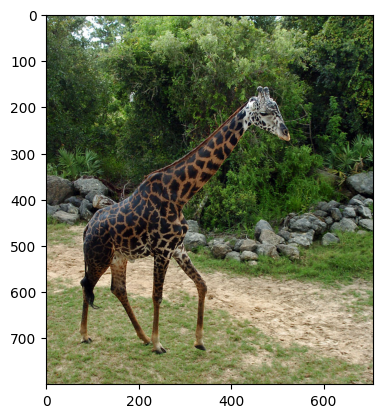

In [7]:
img_path = 'demo/vg1.jpg'
im = Image.open(img_path)
plt.imshow(im)
img = transform(im).unsqueeze(0)

In [8]:
# outputs = reltr_model(img)
# outputs

In [9]:
for param in reltr_model.parameters():
    param.requires_grad = False

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ImitationNetwork(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model)
        )

    def forward(self, x):
        return self.mlp(x)


class MapImitationCNN(nn.Module):
    def __init__(self, num_queries=200, hidden_dim=512):
        super().__init__()

        # 1x1 Convolution to reduce channel size (queries as channels)
        self.conv1 = nn.Conv2d(num_queries, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, num_queries, kernel_size=1)  # Restore queries as channels

        # Adaptive pooling to handle variable spatial sizes
        # self.adaptive_pool = nn.AdaptiveAvgPool2d(self.output_hw)

    def forward(self, x, h, w):
        batch_size, queries, hw = x.shape

        x = x.view(batch_size, queries, h, w)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        # Flatten back
        x = x.view(batch_size, queries, hw)
        return x


from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)

class DeecapRelTR(nn.Module):
    def __init__(self, reltr_model):
        super().__init__()
        self.reltr = reltr_model
        num_layers = reltr_model.transformer.decoder.num_layers
        # so_feature_dim = reltr_model.so_mask_fc.out_features
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.imitation_networks_enitity = nn.ModuleList([
              ImitationNetwork(reltr_model.transformer.d_model).to(device) for _ in range(num_layers)
          ])

        self.imitation_networks_subject = nn.ModuleList([
              ImitationNetwork(reltr_model.transformer.d_model).to(device) for _ in range(num_layers)
          ])

        self.imitation_networks_object = nn.ModuleList([
              ImitationNetwork(reltr_model.transformer.d_model).to(device) for _ in range(num_layers)
          ])

        self.imitation_networks_submap = nn.ModuleList([
              MapImitationCNN().to(device) for _ in range(num_layers)
          ])

        self.imitation_networks_objmap = nn.ModuleList([
              MapImitationCNN().to(device) for _ in range(num_layers)
          ])

        # print("hidden dim", reltr_model.transformer.d_model)

        self.num_layers = num_layers
        self.return_intermediate = True
        self.layer_outputs = []


    def forward(self, samples, confidence_threshold=0.1, verbose=False, layer_exit = -1):
        if isinstance(samples, (list, torch.Tensor)):
            samples = nested_tensor_from_tensor_list(samples)

        # run backbone
        features, pos = self.reltr.backbone(samples)
        src_raw, mask = features[-1].decompose()
        assert mask is not None

        #encoder param mapping
        entity_embed = self.reltr.entity_embed.weight
        triplet_embed = self.reltr.triplet_embed.weight
        pos_embed = pos[-1]
        so_embed = self.reltr.so_embed.weight
        src = self.reltr.input_proj(src_raw)

        bs, c, h, w = src.shape
        src = src.flatten(2).permute(2, 0, 1)
        pos_embed = pos_embed.flatten(2).permute(2, 0, 1)

        # print(len(torch.split(entity_embed, c, dim=1)))
        entity_embed, entity = torch.split(entity_embed, c, dim=1)
        triplet_embed, triplet = torch.split(triplet_embed, [c, 2 * c], dim=1)

        entity_embed = entity_embed.unsqueeze(1).repeat(1, bs, 1)
        triplet_embed = triplet_embed.unsqueeze(1).repeat(1, bs, 1)
        entity = entity.unsqueeze(1).repeat(1, bs, 1)
        triplet = triplet.unsqueeze(1).repeat(1, bs, 1)
        mask = mask.flatten(1)

        memory = self.reltr.transformer.encoder(src, src_key_padding_mask=mask, pos=pos_embed)
        self.memory = memory # save for imitation loss

        # decoder param mapping
        memory_key_padding_mask=mask
        tgt_mask = None
        memory_mask = None
        tgt_key_padding_mask = None
        pos=pos_embed
        entity_pos=entity_embed
        triplet_pos=triplet_embed
        so_pos=so_embed

        # self.reltr.transformer.decoder(entity, triplet, memory, memory_key_padding_mask=mask,
        #                                             pos=pos_embed, entity_pos=entity_embed,
        #                                             triplet_pos=triplet_embed, so_pos=so_embed)

        output_entity = entity
        output_triplet = triplet
        intermediate_entity = []
        intermediate_triplet = []
        intermediate_submaps = []
        intermediate_objmaps = []

        for i,layer in enumerate(self.reltr.transformer.decoder.layers):
            output_entity, output_triplet, sub_maps, obj_maps = layer(output_entity, output_triplet, entity_pos, triplet_pos, so_pos,
                                                                      memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
                                                                      tgt_key_padding_mask=tgt_key_padding_mask,
                                                                      memory_key_padding_mask=memory_key_padding_mask, pos=pos)


            # print("single layer triplet", output_triplet.shape)
            if self.return_intermediate:
                intermediate_entity.append(output_entity)
                intermediate_triplet.append(output_triplet)
                intermediate_submaps.append(sub_maps)
                intermediate_objmaps.append(obj_maps)

            """
            Current flow takes the mth layer representation, calculates logits for object and subject class. If the prob distributions have low entropy,
            ie, high confidence, it uses the imitation layer representations of [m+1, n]th layers and then makes a final prediction.

            Calculate/store the layer of exit.
            """
            # print("Real decoder executed for layer", i)
            if not self.training:
                # Compute confidence score for current layer

                # hs = output_entity
                # hs_sub, hs_obj = torch.split(output_triplet, self.reltr.hidden_dim, dim=-1) #subject and object hidden states for decoder layer m
                # print("intermediate shapes", hs_sub.shape, hs_obj.shape)
                hs = torch.stack(intermediate_entity)
                hs_t = torch.stack(intermediate_triplet)
                
                hs = hs.transpose(1, 2)
                hs_t = hs_t.transpose(1, 2)
                hs_sub, hs_obj = torch.split(hs_t, self.reltr.hidden_dim, dim=-1)

                outputs_class = self.reltr.entity_class_embed(hs)
                outputs_coord = self.reltr.entity_bbox_embed(hs).sigmoid()

                outputs_class_sub = self.reltr.sub_class_embed(hs_sub) #get subject class logits from internal representation of layer m
                outputs_coord_sub = self.reltr.sub_bbox_embed(hs_sub).sigmoid() #get subject class bbox

                outputs_class_obj = self.reltr.obj_class_embed(hs_obj) #get object class logits from internal representation of layer m
                outputs_coord_obj = self.reltr.obj_bbox_embed(hs_obj).sigmoid() #get object class bbox

                entropy = self.compute_confidence(outputs_class, outputs_class_sub, outputs_class_obj, i) #compute entropy over num_class probabilities for layer m output
                if verbose:
                    print('layer:', i)
                    print("entropy", entropy)
                    
                if entropy <= confidence_threshold or i==layer_exit:
                    # Early exit - imitate deeper layers
                    # final_entity = hs
                    # final_subject_hs = hs_sub
                    # final_object_hs = hs_obj
                    # final_submap_hs = sub_maps
                    # final_objmap_hs = obj_maps
                    # print(final_entity.shape, final_subject_hs.shape, final_object_hs.shape, final_submap_hs.shape, final_objmap_hs.shape)


                    final_entity = torch.mean(torch.stack(intermediate_entity), dim=0).transpose(0,1)
                    temp = torch.mean(torch.stack(intermediate_triplet), dim=0).transpose(0,1)
                    final_subject_hs,final_object_hs = torch.split(temp, self.reltr.hidden_dim, dim=-1)
                    final_submap_hs = torch.mean(torch.stack(intermediate_submaps), dim=0)
                    final_objmap_hs = torch.mean(torch.stack(intermediate_objmaps), dim=0)
                    # print(final_entity.shape, final_subject_hs.shape, final_object_hs.shape, final_submap_hs.shape, final_objmap_hs.shape)


                    intermediate_entity_early = intermediate_entity.copy()
                    intermediate_triplet_early = intermediate_triplet.copy()
                    intermediate_submaps_early = intermediate_submaps.copy()
                    intermediate_objmaps_early = intermediate_objmaps.copy()


                    # Apply imitation networks to approximate deeper layers
                    for k in range(i + 1, self.num_layers):
                      # Currently, this doesn't use h_shallow or any feature fusion strategy
                      final_entity = self.imitation_networks_enitity[k](final_entity)
                      final_subject_hs = self.imitation_networks_subject[k](final_subject_hs)
                      final_object_hs = self.imitation_networks_object[k](final_object_hs)
                      # final_submap_hs = self.imitation_networks_submap[k](final_submap_hs)
                      # final_objmap_hs = self.imitation_networks_objmap[k](final_objmap_hs)

                      final_submap_hs = self.imitation_networks_submap[k](final_submap_hs,h,w)
                      final_objmap_hs = self.imitation_networks_objmap[k](final_objmap_hs,h,w)
                      # print("asdf", final_objmap_hs.shape, final_submap_hs.shape)

                      intermediate_entity_early.append(final_entity.transpose(0,1))
                      intermediate_triplet_early.append(torch.cat((final_subject_hs.transpose(0,1), final_object_hs.transpose(0,1)), dim=-1))
                      intermediate_submaps_early.append(final_submap_hs)
                      intermediate_objmaps_early.append(final_objmap_hs)


                    hs = torch.stack(intermediate_entity_early)
                    hs_t = torch.stack(intermediate_triplet_early)
                    sub_maps = torch.stack(intermediate_submaps_early)
                    obj_maps = torch.stack(intermediate_objmaps_early)

                    so_masks = torch.cat((sub_maps.reshape(sub_maps.shape[0], bs, sub_maps.shape[2], 1, h, w),
                              obj_maps.reshape(obj_maps.shape[0], bs, obj_maps.shape[2], 1, h, w)), dim=3) #decoder + imitation stack
                    # hs_t = hs_t.transpose(1, 2)
                    hs = hs.transpose(1, 2)
                    hs_t = hs_t.transpose(1, 2)
                    memory_permute = memory.permute(1, 2, 0).view(bs, c, h, w)
                    so_masks = so_masks.detach()
                    so_masks = self.reltr.so_mask_conv(so_masks.view(-1, 2, src_raw.shape[-2],src_raw.shape[-1])).view(hs_t.shape[0], hs_t.shape[1], hs_t.shape[2],-1)
                    so_masks = self.reltr.so_mask_fc(so_masks)

                    hs_sub, hs_obj = torch.split(hs_t, self.reltr.hidden_dim, dim=-1)

                    outputs_class = self.reltr.entity_class_embed(hs)
                    outputs_coord = self.reltr.entity_bbox_embed(hs).sigmoid()

                    outputs_class_sub = self.reltr.sub_class_embed(hs_sub)
                    outputs_coord_sub = self.reltr.sub_bbox_embed(hs_sub).sigmoid()
                    # print("output class shape for sub", outputs_class_sub.shape)

                    outputs_class_obj = self.reltr.obj_class_embed(hs_obj)
                    outputs_coord_obj = self.reltr.obj_bbox_embed(hs_obj).sigmoid()
                    # print("output class shape for obj", outputs_class_obj.shape)

                    outputs_class_rel = self.reltr.rel_class_embed(torch.cat((hs_sub, hs_obj, so_masks), dim=-1))
                    out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1],
                            'sub_logits': outputs_class_sub[-1], 'sub_boxes': outputs_coord_sub[-1],
                            'obj_logits': outputs_class_obj[-1], 'obj_boxes': outputs_coord_obj[-1],
                            'rel_logits': outputs_class_rel[-1]}
                    if verbose:
                      print("early exit after layer", i)
                    if self.reltr.aux_loss:
                      out['aux_outputs'] = self.reltr._set_aux_loss(outputs_class, outputs_coord, outputs_class_sub, outputs_coord_sub,
                                                    outputs_class_obj, outputs_coord_obj, outputs_class_rel)
                    return out

        #TODO: training and imitation loss functions
        hs = torch.stack(intermediate_entity)
        hs_t = torch.stack(intermediate_triplet)
        sub_maps = torch.stack(intermediate_submaps)
        obj_maps = torch.stack(intermediate_objmaps)
        # print("sub_maps, obj_maps shape", sub_maps.shape, obj_maps.shape)

        # self.entity_outputs = hs.transpose(1, 2)
        # self.triplet_outputs = hs_t.transpose(1, 2)
        self.entity_outputs = hs
        self.triplet_outputs = hs_t
        self.submap_outputs = sub_maps
        self.objmap_outputs = obj_maps
        self.h = h
        self.w = w
        self.bs = bs
        self.c = c
        self.src_raw_shape = src_raw.shape

        #num_layers, bs, num_queries,1,h,w
        so_masks = torch.cat((sub_maps.reshape(sub_maps.shape[0], bs, sub_maps.shape[2], 1, h, w),
                              obj_maps.reshape(obj_maps.shape[0], bs, obj_maps.shape[2], 1, h, w)), dim=3)
        # print("hs, hs_t before", hs.shape, hs_t.shape)
        hs = hs.transpose(1, 2)
        hs_t = hs_t.transpose(1, 2)
        # print("hs, hs_t", hs.shape, hs_t.shape)
        memory_permute = memory.permute(1, 2, 0).view(bs, c, h, w)

        # print("shape test", hs.shape)
        # print(hs_t.shape)

        so_masks = so_masks.detach()
        # print("so shape", so_masks.shape)
        so_masks = self.reltr.so_mask_conv(so_masks.view(-1, 2, src_raw.shape[-2],src_raw.shape[-1])).view(hs_t.shape[0], hs_t.shape[1], hs_t.shape[2],-1)
        so_masks = self.reltr.so_mask_fc(so_masks)

        hs_sub, hs_obj = torch.split(hs_t, self.reltr.hidden_dim, dim=-1)

        self.sub_outputs = hs_sub
        self.obj_outputs = hs_obj
        self.so_fc_outputs = so_masks

        # print("intermediate shapes", hs_sub.shape, hs_obj.shape)
        outputs_class = self.reltr.entity_class_embed(hs)
        outputs_coord = self.reltr.entity_bbox_embed(hs).sigmoid()

        outputs_class_sub = self.reltr.sub_class_embed(hs_sub)
        outputs_coord_sub = self.reltr.sub_bbox_embed(hs_sub).sigmoid()
        # print("output class shape for sub", outputs_class_sub.shape)

        outputs_class_obj = self.reltr.obj_class_embed(hs_obj)
        outputs_coord_obj = self.reltr.obj_bbox_embed(hs_obj).sigmoid()
        # print("output class shape for obj", outputs_class_obj.shape)

        outputs_class_rel = self.reltr.rel_class_embed(torch.cat((hs_sub, hs_obj, so_masks), dim=-1))
        # print("output class shape for rel", outputs_class_rel.shape)

        out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1],
               'sub_logits': outputs_class_sub[-1], 'sub_boxes': outputs_coord_sub[-1],
               'obj_logits': outputs_class_obj[-1], 'obj_boxes': outputs_coord_obj[-1],
               'rel_logits': outputs_class_rel[-1]}
        if self.reltr.aux_loss:
            out['aux_outputs'] = self.reltr._set_aux_loss(outputs_class, outputs_coord, outputs_class_sub, outputs_coord_sub,
                                                    outputs_class_obj, outputs_coord_obj, outputs_class_rel)
        # print("all layers executed")
        return out
        # return self.reltr.predict_triplets(hs_sub, hs_obj), self.num_layers - 1


    def compute_confidence(self, entity_queries, subject_queries, object_queries, layer_idx):
      combined = torch.cat([subject_queries, object_queries], dim=0)
      prob = torch.nn.functional.softmax(combined, dim=-1)
      return -torch.sum(prob * torch.log(prob), dim=-1).mean()


    def compute_imitation_loss(self, criterion, targets):
        imitation_loss_total = 0.0
        task_loss_total = 0.0

        intermediate_entity = []
        intermediate_triplet = []
        intermediate_submaps = []
        intermediate_objmaps = []

        # For each layer m (except the last one)
        for m in range(self.num_layers- 1):
            # Get output from layer m
            hs_m = self.entity_outputs[m]
            hs_t = self.triplet_outputs[m]
            submap_m = self.submap_outputs[m]
            objmap_m = self.objmap_outputs[m]
            subject_m, object_m = torch.split(hs_t, self.reltr.hidden_dim, dim=-1)

            intermediate_entity.append(hs_m)
            intermediate_triplet.append(hs_t)
            intermediate_submaps.append(submap_m)
            intermediate_objmaps.append(objmap_m)


            intermediate_entity_early = intermediate_entity.copy()
            intermediate_triplet_early = intermediate_triplet.copy()
            intermediate_submaps_early = intermediate_submaps.copy()
            intermediate_objmaps_early = intermediate_objmaps.copy()

            # print("intermediate shape", hs_m.shape, hs_t.shape)

            # imit_hs_k = hs_m
            # imit_subject_k = subject_m
            # imit_object_k = object_m
            # imit_submap_k = submap_m
            # imit_objmap_k = objmap_m

            # print("stack shape test", torch.stack(intermediate_entity).shape)
            # print("stack shape test", torch.stack(intermediate_entity).transpose(1,2).shape)
            imit_hs_k = torch.mean(torch.stack(intermediate_entity), dim=0).transpose(0,1)
            temp = torch.mean(torch.stack(intermediate_triplet), dim=0).transpose(0,1)
            imit_subject_k,imit_object_k = torch.split(temp, self.reltr.hidden_dim, dim=-1)
            imit_submap_k = torch.mean(torch.stack(intermediate_submaps), dim=0)
            imit_objmap_k = torch.mean(torch.stack(intermediate_objmaps), dim=0)
            # print("transpose shapes -", imit_hs_k.shape, imit_subject_k.shape, imit_object_k.shape)

            layer_imitation_loss = 0.0

            # For each deeper layer k
            for k in range(m + 1, self.num_layers):
                # print("imit",m,k)
                # Get the ground truth deep representation
                entity_k = self.entity_outputs[k]
                hs_t = self.triplet_outputs[k]
                submap_k = self.submap_outputs[k]
                objmap_k = self.objmap_outputs[k]
                subject_k, object_k = torch.split(hs_t, self.reltr.hidden_dim, dim=-1)

                # _, _, hw = submap_k.shape
                # h = int(hw**0.5)  # Assume square
                # w = hw // h  # Ensure h*w = hw
                # imitated_entity_k = self.imitation_networks_enitity[k](hs_m)
                # imitated_subject_k = self.imitation_networks_subject[k](subject_m)
                # imitated_object_k = self.imitation_networks_object[k](object_m)
                # imitated_submap_k = self.imitation_networks_submap[k](submap_m, self.h,self.w)
                # imitated_objmap_k = self.imitation_networks_objmap[k](objmap_m, self.h,self.w)

                imit_hs_k = self.imitation_networks_enitity[k](imit_hs_k)
                imit_subject_k = self.imitation_networks_subject[k](imit_subject_k)
                imit_object_k = self.imitation_networks_object[k](imit_object_k)
                imit_submap_k = self.imitation_networks_submap[k](imit_submap_k, self.h,self.w)
                imit_objmap_k = self.imitation_networks_objmap[k](imit_objmap_k, self.h,self.w)
                # print("training shape -", imit_hs_k.shape, imit_subject_k.shape, imit_object_k.shape)


                # Compute cosine similarity loss
                entity_sim = 1 - F.cosine_similarity(imit_hs_k.transpose(0,1), entity_k.detach(), dim=-1).mean()
                subject_sim = 1 - F.cosine_similarity(imit_subject_k.transpose(0,1), subject_k.detach(), dim=-1).mean()
                object_sim = 1 - F.cosine_similarity(imit_object_k.transpose(0,1), object_k.detach(), dim=-1).mean()
                submap_sim = 1 - F.cosine_similarity(imit_submap_k, submap_k.detach(), dim=-1).mean()
                objmap_sim = 1 - F.cosine_similarity(imit_objmap_k, objmap_k.detach(), dim=-1).mean()

                # imitation_loss += subject_sim + object_sim + submap_sim + objmap_sim + entity_sim

                layer_imitation_loss += entity_sim + subject_sim + object_sim + submap_sim + objmap_sim


                intermediate_entity_early.append(imit_hs_k.transpose(0,1))
                intermediate_triplet_early.append(torch.cat((imit_subject_k.transpose(0,1), imit_object_k.transpose(0,1)), dim=-1))
                intermediate_submaps_early.append(imit_submap_k)
                intermediate_objmaps_early.append(imit_objmap_k)

            imitation_loss_total += layer_imitation_loss

            hs = torch.stack(intermediate_entity_early)
            hs_t = torch.stack(intermediate_triplet_early)
            sub_maps = torch.stack(intermediate_submaps_early)
            obj_maps = torch.stack(intermediate_objmaps_early)

            so_masks = torch.cat((sub_maps.reshape(sub_maps.shape[0], self.bs, sub_maps.shape[2], 1, self.h, self.w),
                      obj_maps.reshape(obj_maps.shape[0], self.bs, obj_maps.shape[2], 1, self.h, self.w)), dim=3) #decoder + imitation stack
            hs = hs.transpose(1, 2)
            hs_t = hs_t.transpose(1, 2)
            memory_permute = self.memory.permute(1, 2, 0).view(self.bs, self.c, self.h, self.w)
            so_masks = so_masks.detach()
            so_masks = self.reltr.so_mask_conv(so_masks.view(-1, 2, self.src_raw_shape[-2],self.src_raw_shape[-1])).view(hs_t.shape[0], hs_t.shape[1], hs_t.shape[2],-1)
            so_masks = self.reltr.so_mask_fc(so_masks)

            hs_sub, hs_obj = torch.split(hs_t, self.reltr.hidden_dim, dim=-1)

            outputs_class = self.reltr.entity_class_embed(hs)
            outputs_coord = self.reltr.entity_bbox_embed(hs).sigmoid()

            outputs_class_sub = self.reltr.sub_class_embed(hs_sub)
            outputs_coord_sub = self.reltr.sub_bbox_embed(hs_sub).sigmoid()
            # print("output class shape for sub", outputs_class_sub.shape)

            outputs_class_obj = self.reltr.obj_class_embed(hs_obj)
            outputs_coord_obj = self.reltr.obj_bbox_embed(hs_obj).sigmoid()
            # print("output class shape for obj", outputs_class_obj.shape)

            outputs_class_rel = self.reltr.rel_class_embed(torch.cat((hs_sub, hs_obj, so_masks), dim=-1))

            out = {'pred_logits': outputs_class[-1], 'pred_boxes': outputs_coord[-1],
                    'sub_logits': outputs_class_sub[-1], 'sub_boxes': outputs_coord_sub[-1],
                    'obj_logits': outputs_class_obj[-1], 'obj_boxes': outputs_coord_obj[-1],
                    'rel_logits': outputs_class_rel[-1]}

            loss_dict = criterion(out, targets)
            # print("criterion", loss_dict)

            weight_dict = criterion.weight_dict
            layer_task_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            task_loss_total += layer_task_loss


        imitation_loss_avg = imitation_loss_total / (self.num_layers * (self.num_layers - 1) / 2)
        task_loss_avg = task_loss_total / (self.num_layers - 1)


        # return imitation_loss / (self.num_layers * (self.num_layers - 1)), losses
        return imitation_loss_avg, task_loss_avg

In [11]:
from types import SimpleNamespace

device = "cuda" if torch.cuda.is_available() else "cpu"

args = {
    'bbox_loss_coef': 5,
    'giou_loss_coef': 2,
    'rel_loss_coef': 1,
    'aux_loss': False,
    'set_cost_class': 1,
    'set_cost_bbox': 5,
    'set_cost_giou': 2,
    'set_iou_threshold':0.7,
    'dataset': 'vg',
    'device': device,
    'eos_coef': 0.1,
    'seed': 42,
    'lr_backbone': 1e-5,
    'lr': 1e-5,
    'lr_drop': 200,
    'weight_decay': 1e-4,
    'ann_path': 'data/vg/',
    'img_folder': 'data/vg/images',
    'eval': False,
    'batch_size': 10,
    'epochs': 10,
    'num_workers': 2,
}
args = SimpleNamespace(**args)

In [12]:
from models.backbone import build_backbone
from models.matcher import build_matcher
from models.transformer import build_transformer
from models.reltr import SetCriterion, PostProcess
from datasets import build_dataset
import util.misc as utils
from torch.utils.data import DataLoader, DistributedSampler


def build_model(args):
  num_classes = 151 if args.dataset != 'oi' else 289 # some entity categories in OIV6 are deactivated.
  num_rel_classes = 51 if args.dataset != 'oi' else 31

  device = torch.device(args.device)

  matcher = build_matcher(args)

  model = DeecapRelTR(reltr_model)

  model.to(device)

  weight_dict = {'loss_ce': 1, 'loss_bbox': args.bbox_loss_coef}
  weight_dict['loss_giou'] = args.giou_loss_coef
  weight_dict['loss_rel'] = args.rel_loss_coef

  # TODO this is a hack
  if args.aux_loss:
      aux_weight_dict = {}
      for i in range(args.dec_layers - 1):
          aux_weight_dict.update({k + f'_{i}': v for k, v in weight_dict.items()})
      weight_dict.update(aux_weight_dict)

  losses = ['labels', 'boxes', 'cardinality', "relations"]

  criterion = SetCriterion(num_classes, num_rel_classes, matcher=matcher, weight_dict=weight_dict,
                            eos_coef=args.eos_coef, losses=losses)
  criterion.to(device)
  postprocessors = {'bbox': PostProcess()}
  return model, criterion, postprocessors

In [13]:
utils.init_distributed_mode(args)
# print("git:\n  {}\n".format(utils.get_sha()))
# if args.frozen_weights is not None:
#     assert args.masks, "Frozen training is meant for segmentation only"
# print(args)

device = torch.device(args.device)

# fix the seed for reproducibility
seed = args.seed + utils.get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model, criterion, postprocessors = build_model(args)
model.to(device)

# model_without_ddp = model

# if args.distributed:
#     model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
#     model_without_ddp = model.module
# n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print('number of params:', n_parameters)

# param_dicts = [
#     {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
#     {
#         "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
#         "lr": args.lr_backbone,
#     },
# ]
# optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                              # weight_decay=args.weight_decay)

optimizer = torch.optim.Adam([
    {'params': model.imitation_networks_enitity.parameters(), 'lr': 1e-4},
    {'params': model.imitation_networks_subject.parameters(), 'lr': 1e-4},
    {'params': model.imitation_networks_object.parameters(), 'lr': 1e-4},
    {'params': model.imitation_networks_submap.parameters(), 'lr': 1e-4},
    {'params': model.imitation_networks_objmap.parameters(), 'lr': 1e-4},
])

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

dataset_train = build_dataset(image_set='train', args=args) #need to add dataset
dataset_val = build_dataset(image_set='val', args=args)


if args.distributed:
        sampler_train = DistributedSampler(dataset_train)
        sampler_val = DistributedSampler(dataset_val, shuffle=False)
else:
    sampler_train = torch.utils.data.RandomSampler(dataset_train)
    sampler_val = torch.utils.data.SequentialSampler(dataset_val)


batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, args.batch_size, sampler=sampler_val,
                              drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)


Not using distributed mode
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
loading annotations into memory...
Done (t=0.36s)
creating index...
index created!


In [ ]:
# model.eval()
# out = model(img,confidence_threshold=0.5)

In [14]:
model.load_state_dict(torch.load('/kaggle/input/m/sarikasingh931/deecap-reltr/pytorch/default/3/avg_mix_50_0.7.pth', map_location=torch.device('cuda')))
model.to(device)

/tmp/ipykernel_31/2570279070.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/m/sarikasingh931/deecap-reltr/pytorch/defaul

DeecapRelTR(
  (reltr): RelTR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn_entity): MultiheadAttention(
 

In [ ]:
# Lambda for balancing imitation loss
lambda_imitation = 0.7
epochs = 20

print("Using lambda =",lambda_imitation)
print("LR -", args.lr)

# Set the model to training mode
model.train()

for epoch in range(epochs):
    running_loss = 0.0  # To accumulate the loss for each epoch
    for batch_idx, (images, targets) in enumerate(data_loader_train):

        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        predictions = model(images)

        imitation_loss, task_losses = model.compute_imitation_loss(criterion, targets)

        total_loss = lambda_imitation * imitation_loss + (1 - lambda_imitation) * task_losses

        # Backward pass (calculate gradients)
        total_loss.backward()

        # Update the model parameters
        optimizer.step()
        # torch.cuda.empty_cache()

        # Accumulate the running loss for logging
        running_loss += total_loss.item()

        if (batch_idx + 1) % 10 == 0:
            avg_loss = running_loss / (batch_idx + 1)  # Calculate average loss
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(data_loader_train)}], "
                  f"Avg Loss: {avg_loss:.4f}, Imitation Loss: {imitation_loss.item():.4f}, Task Loss: {task_losses.item():.4f}")

    avg_epoch_loss = running_loss / len(data_loader_train)
    print(f"End of Epoch [{epoch+1}/{epochs}], Average Total Loss: {avg_epoch_loss:.4f}")
    # lr_scheduler.step()

In [ ]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/avg_mix_50_0.7.pth')

In [15]:
from PIL import Image
import os

# def resize_image(image, new_width, new_height):
#     resized_image = image.resize((new_width, new_height))
#     return resized_image

In [16]:
model = DeecapRelTR(reltr_model)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load('/kaggle/input/m/sarikasingh931/deecap-reltr/pytorch/default/3/avg_mix_50_0.7.pth', map_location=torch.device(device)))
model.eval()

# # The checkpoint is pretrained on Visual Genome
# device = "cuda" if torch.cuda.is_available() else "cpu"
# ckpt = torch.load('ckpt/checkpoint0149.pth', map_location=torch.device(device), weights_only=False)
# reltr_model.load_state_dict(ckpt['model'])
# reltr_model.eval()

/tmp/ipykernel_31/316280611.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/m/sarikasingh931/deecap-reltr/pytorch/default

DeecapRelTR(
  (reltr): RelTR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (decoder): TransformerDecoder(
        (layers): ModuleList(
          (0-5): 6 x TransformerDecoderLayer(
            (self_attn_entity): MultiheadAttention(
 

In [17]:
CLASSES = [ 'N/A', 'airplane', 'animal', 'arm', 'bag', 'banana', 'basket', 'beach', 'bear', 'bed', 'bench', 'bike',
                'bird', 'board', 'boat', 'book', 'boot', 'bottle', 'bowl', 'box', 'boy', 'branch', 'building',
                'bus', 'cabinet', 'cap', 'car', 'cat', 'chair', 'child', 'clock', 'coat', 'counter', 'cow', 'cup',
                'curtain', 'desk', 'dog', 'door', 'drawer', 'ear', 'elephant', 'engine', 'eye', 'face', 'fence',
                'finger', 'flag', 'flower', 'food', 'fork', 'fruit', 'giraffe', 'girl', 'glass', 'glove', 'guy',
                'hair', 'hand', 'handle', 'hat', 'head', 'helmet', 'hill', 'horse', 'house', 'jacket', 'jean',
                'kid', 'kite', 'lady', 'lamp', 'laptop', 'leaf', 'leg', 'letter', 'light', 'logo', 'man', 'men',
                'motorcycle', 'mountain', 'mouth', 'neck', 'nose', 'number', 'orange', 'pant', 'paper', 'paw',
                'people', 'person', 'phone', 'pillow', 'pizza', 'plane', 'plant', 'plate', 'player', 'pole', 'post',
                'pot', 'racket', 'railing', 'rock', 'roof', 'room', 'screen', 'seat', 'sheep', 'shelf', 'shirt',
                'shoe', 'short', 'sidewalk', 'sign', 'sink', 'skateboard', 'ski', 'skier', 'sneaker', 'snow',
                'sock', 'stand', 'street', 'surfboard', 'table', 'tail', 'tie', 'tile', 'tire', 'toilet', 'towel',
                'tower', 'track', 'train', 'tree', 'truck', 'trunk', 'umbrella', 'vase', 'vegetable', 'vehicle',
                'wave', 'wheel', 'window', 'windshield', 'wing', 'wire', 'woman', 'zebra']

REL_CLASSES = ['__background__', 'above', 'across', 'against', 'along', 'and', 'at', 'attached to', 'behind',
                'belonging to', 'between', 'carrying', 'covered in', 'covering', 'eating', 'flying in', 'for',
                'from', 'growing on', 'hanging from', 'has', 'holding', 'in', 'in front of', 'laying on',
                'looking at', 'lying on', 'made of', 'mounted on', 'near', 'of', 'on', 'on back of', 'over',
                'painted on', 'parked on', 'part of', 'playing', 'riding', 'says', 'sitting on', 'standing on',
                'to', 'under', 'using', 'walking in', 'walking on', 'watching', 'wearing', 'wears', 'with']

In [18]:
def visualize_layer(model, img, t = 0, layer_exit=-1):
    model.eval()
    # # save the attention weights
    conv_features, dec_attn_weights_sub, dec_attn_weights_obj = [], [], []
    imitation_weights_sub, imitation_weights_obj = [], []
    hooks = [
        model.reltr.backbone[-2].register_forward_hook(
            lambda self, input, output: conv_features.append(output)
        ),
        model.reltr.transformer.decoder.layers[0].cross_attn_sub.register_forward_hook( #make this take the "real decoder layer"
            lambda self, input, output: dec_attn_weights_sub.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[1].cross_attn_sub.register_forward_hook( #make this take the "real decoder layer"
            lambda self, input, output: dec_attn_weights_sub.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[2].cross_attn_sub.register_forward_hook( #make this take the "real decoder layer"
            lambda self, input, output: dec_attn_weights_sub.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[3].cross_attn_sub.register_forward_hook( #make this take the "real decoder layer"
            lambda self, input, output: dec_attn_weights_sub.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[4].cross_attn_sub.register_forward_hook( #make this take the "real decoder layer"
            lambda self, input, output: dec_attn_weights_sub.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[5].cross_attn_sub.register_forward_hook( #make this take the "real decoder layer"
            lambda self, input, output: dec_attn_weights_sub.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[0].cross_attn_obj.register_forward_hook(
            lambda self, input, output: dec_attn_weights_obj.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[1].cross_attn_obj.register_forward_hook(
            lambda self, input, output: dec_attn_weights_obj.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[2].cross_attn_obj.register_forward_hook(
            lambda self, input, output: dec_attn_weights_obj.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[3].cross_attn_obj.register_forward_hook(
            lambda self, input, output: dec_attn_weights_obj.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[4].cross_attn_obj.register_forward_hook(
            lambda self, input, output: dec_attn_weights_obj.append(output[1])
        ),
        model.reltr.transformer.decoder.layers[5].cross_attn_obj.register_forward_hook(
            lambda self, input, output: dec_attn_weights_obj.append(output[1])
        ),
        model.imitation_networks_submap[-1].register_forward_hook(
            lambda self, input, output: imitation_weights_sub.append(output)
        ),
        model.imitation_networks_objmap[-1].register_forward_hook(
            lambda self, input, output: imitation_weights_obj.append(output)
        )
      ]


    # propagate through the model
    start = time.time()
    outputs = model(img, confidence_threshold=t, layer_exit=layer_exit)
    end = time.time()
    print("Execution time", end-start)

    # keep only predictions with >0.3 confidence
    keep_prob = 0.3
    probas = outputs['rel_logits'].softmax(-1)[0, :, :-1]
    probas_sub = outputs['sub_logits'].softmax(-1)[0, :, :-1]
    probas_obj = outputs['obj_logits'].softmax(-1)[0, :, :-1]
    keep = torch.logical_and(probas.max(-1).values > keep_prob, torch.logical_and(probas_sub.max(-1).values > keep_prob,
                                                                            probas_obj.max(-1).values > keep_prob))

    sub_bboxes_scaled = rescale_bboxes(outputs['sub_boxes'][0, keep], im.size).cpu()
    obj_bboxes_scaled = rescale_bboxes(outputs['obj_boxes'][0, keep], im.size).cpu()

    topk = 10 # display up to 10 images
    keep_queries = torch.nonzero(keep, as_tuple=True)[0]
    indices = torch.argsort(-probas[keep_queries].max(-1)[0] * probas_sub[keep_queries].max(-1)[0] * probas_obj[keep_queries].max(-1)[0])[:topk].cpu()
    keep_queries = keep_queries[indices]

    with torch.no_grad():

      for hook in hooks:
          hook.remove()

      decoder_execution_layer = len(dec_attn_weights_sub)

      conv_features = conv_features[-1]
      dec_attn_weights_sub = dec_attn_weights_sub[-1].cpu()
      dec_attn_weights_obj = dec_attn_weights_obj[-1].cpu()
      imitation_weights_sub = imitation_weights_sub[0].cpu()
      imitation_weights_obj = imitation_weights_obj[0].cpu()

      print("Real decoders executed till layer",decoder_execution_layer-1)

      # get the feature map shape
      h, w = conv_features['0'].tensors.shape[-2:]
      im_w, im_h = im.size

      fig, axs = plt.subplots(ncols=len(indices), nrows=5, figsize=(22, 7))
      for idx, ax_i, (sxmin, symin, sxmax, symax), (oxmin, oymin, oxmax, oymax) in \
              zip(keep_queries, axs.T, sub_bboxes_scaled[indices], obj_bboxes_scaled[indices]):
          ax = ax_i[0]
          ax.imshow(dec_attn_weights_sub[0, idx].view(h, w))
          ax.axis('off')
          ax.set_title(f'query id: {idx.item()}')
          ax = ax_i[1]
          ax.imshow(dec_attn_weights_obj[0, idx].view(h, w))
          ax.axis('off')
          ax = ax_i[2]
          ax.imshow(imitation_weights_sub[0, idx].view(h, w))
          ax.axis('off')
          ax = ax_i[3]
          ax.imshow(imitation_weights_obj[0, idx].view(h, w))
          ax.axis('off')
          ax = ax_i[4]
          ax.imshow(im)
          ax.add_patch(plt.Rectangle((sxmin, symin), sxmax - sxmin, symax - symin,
                                      fill=False, color='blue', linewidth=2.5))
          ax.add_patch(plt.Rectangle((oxmin, oymin), oxmax - oxmin, oymax - oymin,
                                      fill=False, color='orange', linewidth=2.5))

          ax.axis('off')
          ax.set_title(CLASSES[probas_sub[idx].argmax()]+' '+REL_CLASSES[probas[idx].argmax()]+' '+CLASSES[probas_obj[idx].argmax()], fontsize=10)

      fig.tight_layout()
      plt.show() # show the output

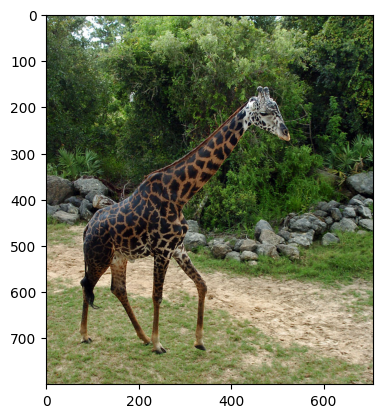

In [19]:
img_path = 'demo/vg1.jpg'
# img_path = 'data/vg/images/103.jpg'
im= Image.open(img_path)
plt.imshow(im)
# im = resize_image(im, 708,800)
img = transform(im).unsqueeze(0)
img = img.to(device)

In [20]:
# see entropy of all layers
outputs = model(img, verbose=True)

layer: 0
entropy tensor(0.4260, device='cuda:0')
layer: 1
entropy tensor(0.4106, device='cuda:0')
layer: 2
entropy tensor(0.4109, device='cuda:0')
layer: 3
entropy tensor(0.3975, device='cuda:0')
layer: 4
entropy tensor(0.3882, device='cuda:0')
layer: 5
entropy tensor(0.3837, device='cuda:0')


Execution time 0.05108952522277832
Real decoders executed till layer 0


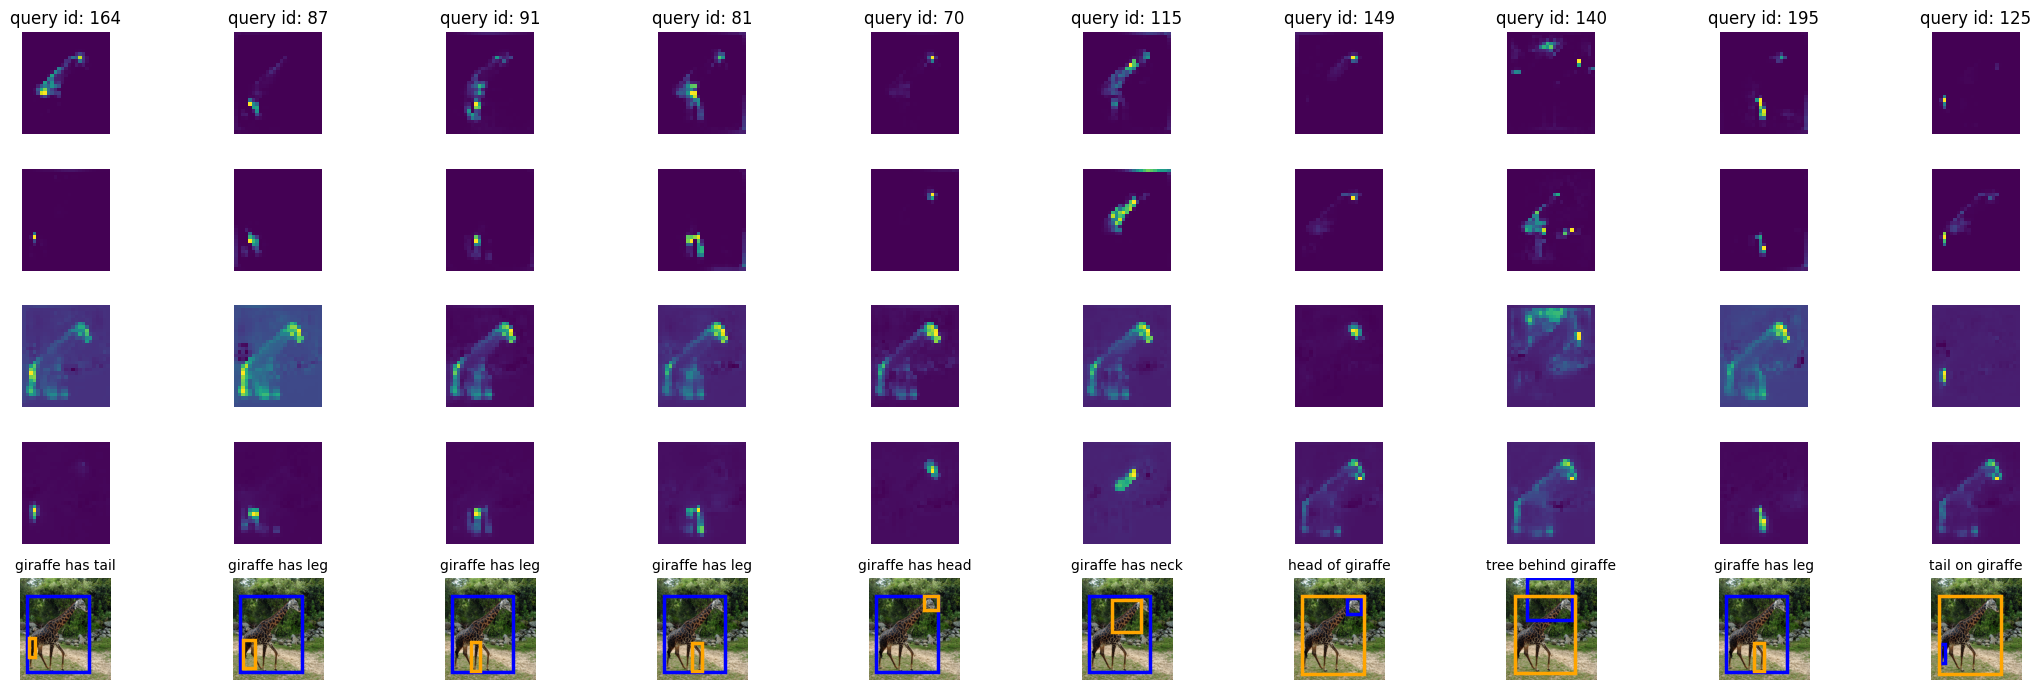

In [21]:
visualize_layer(model, img, layer_exit=0)

Execution time 0.04941701889038086
Real decoders executed till layer 1


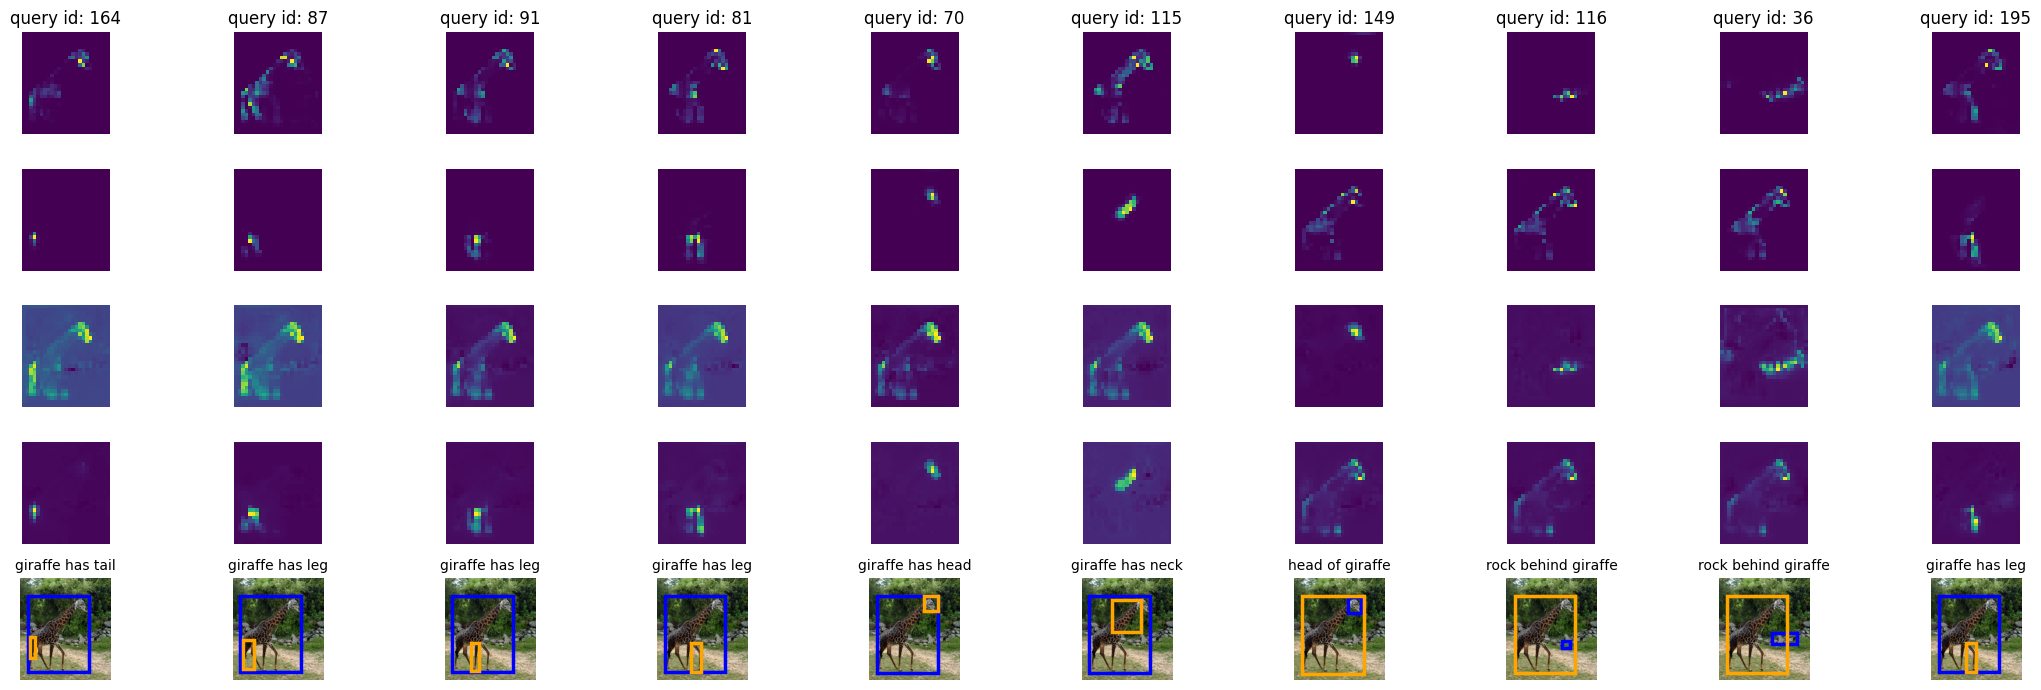

In [22]:
visualize_layer(model, img, layer_exit=1)

Execution time 0.05293154716491699
Real decoders executed till layer 2


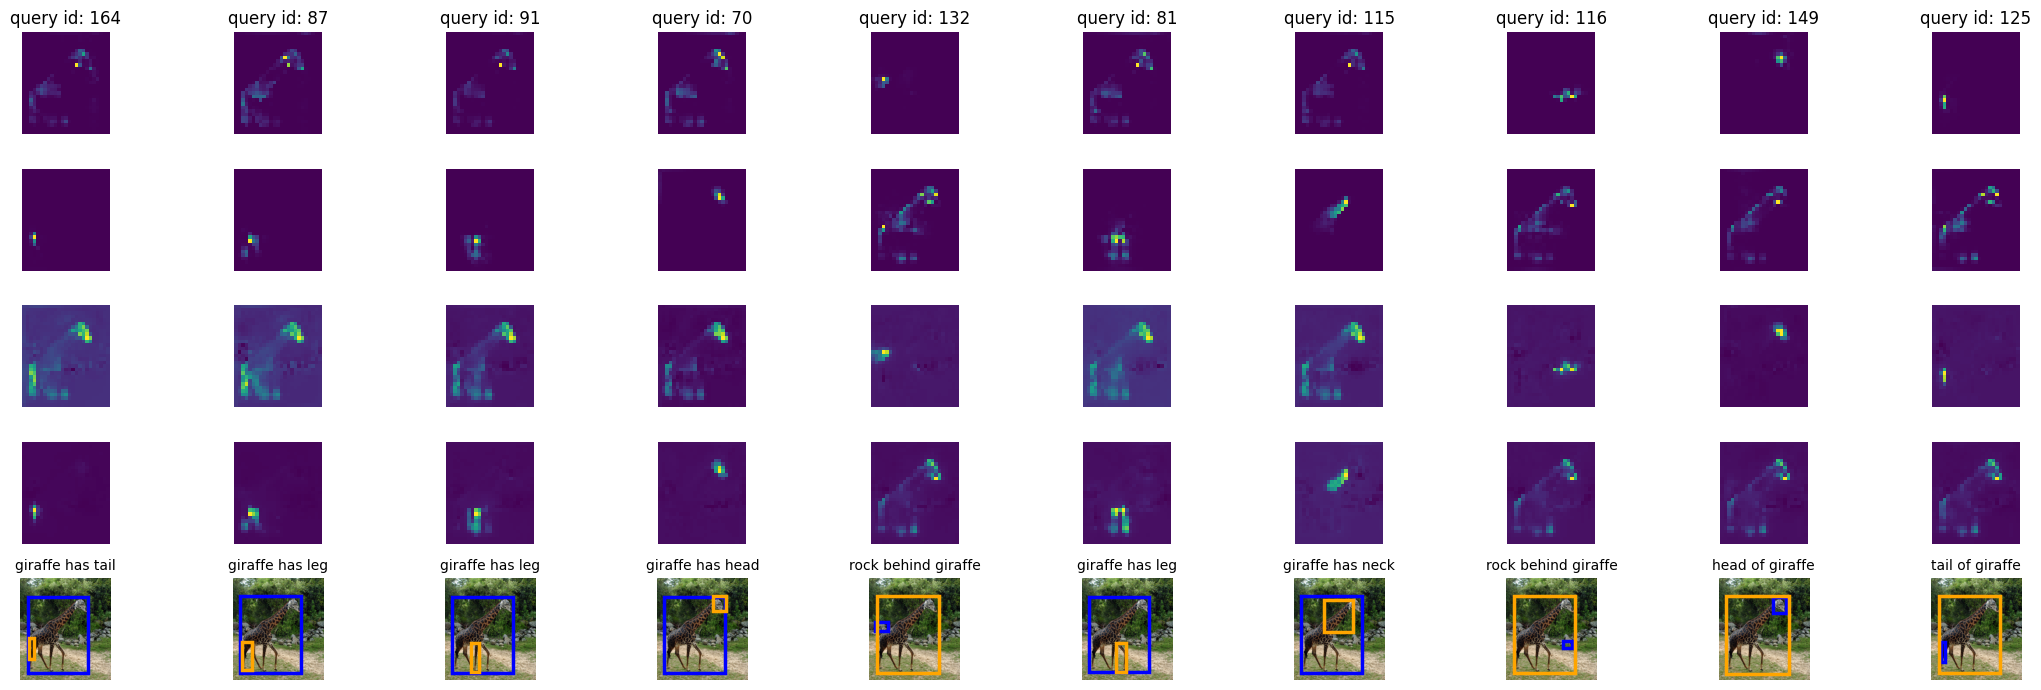

In [23]:
visualize_layer(model, img, layer_exit=2)

Execution time 0.05668139457702637
Real decoders executed till layer 3


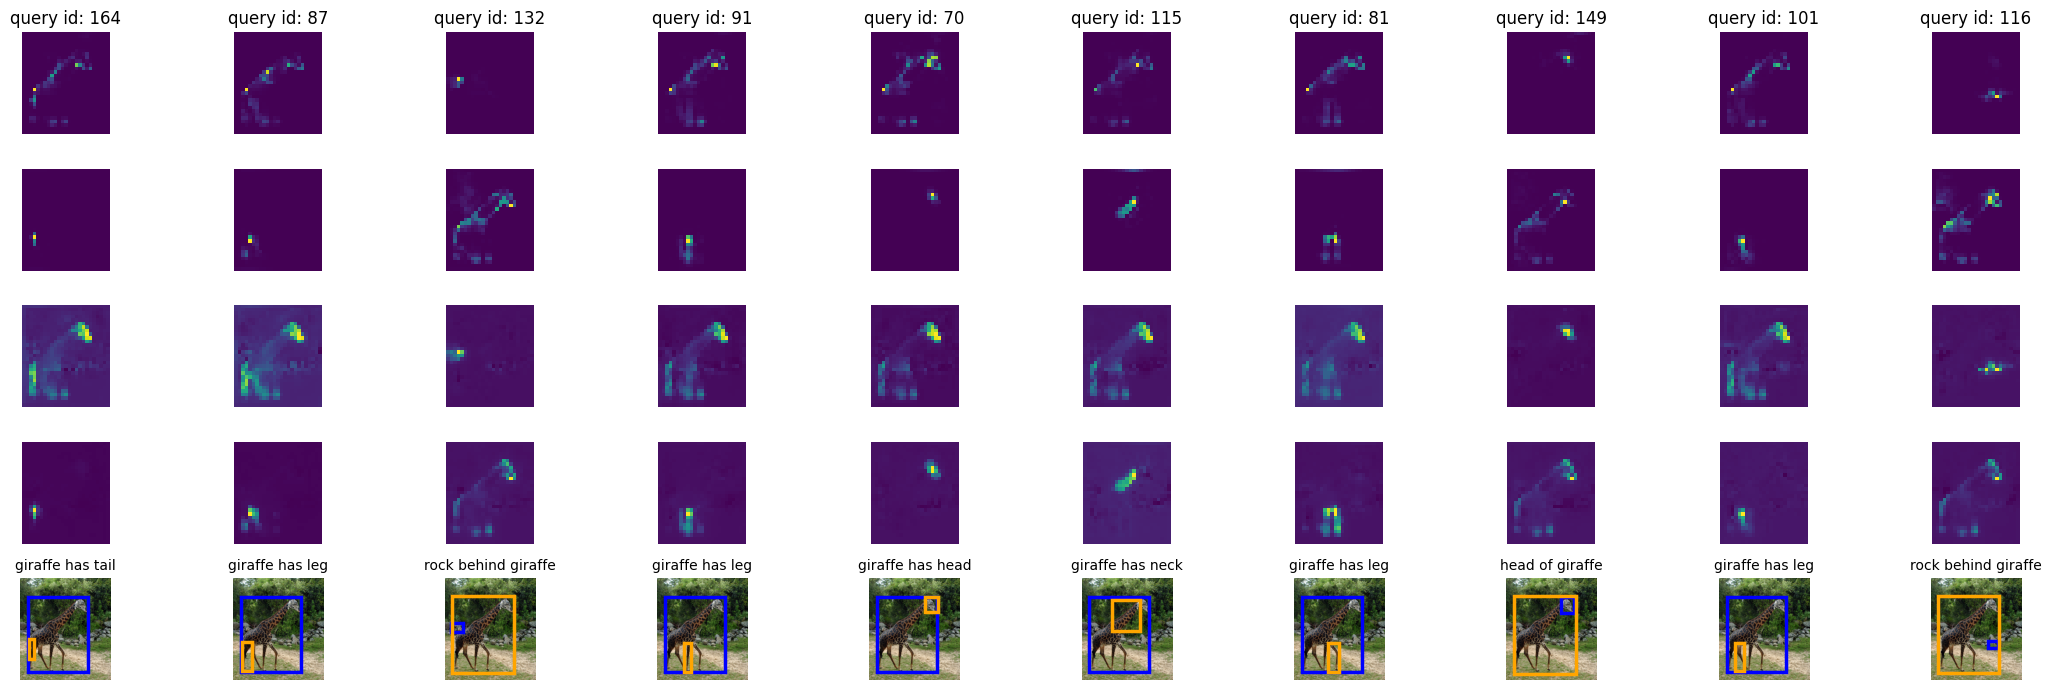

In [24]:
visualize_layer(model, img, layer_exit=3)

Execution time 0.06035971641540527
Real decoders executed till layer 4


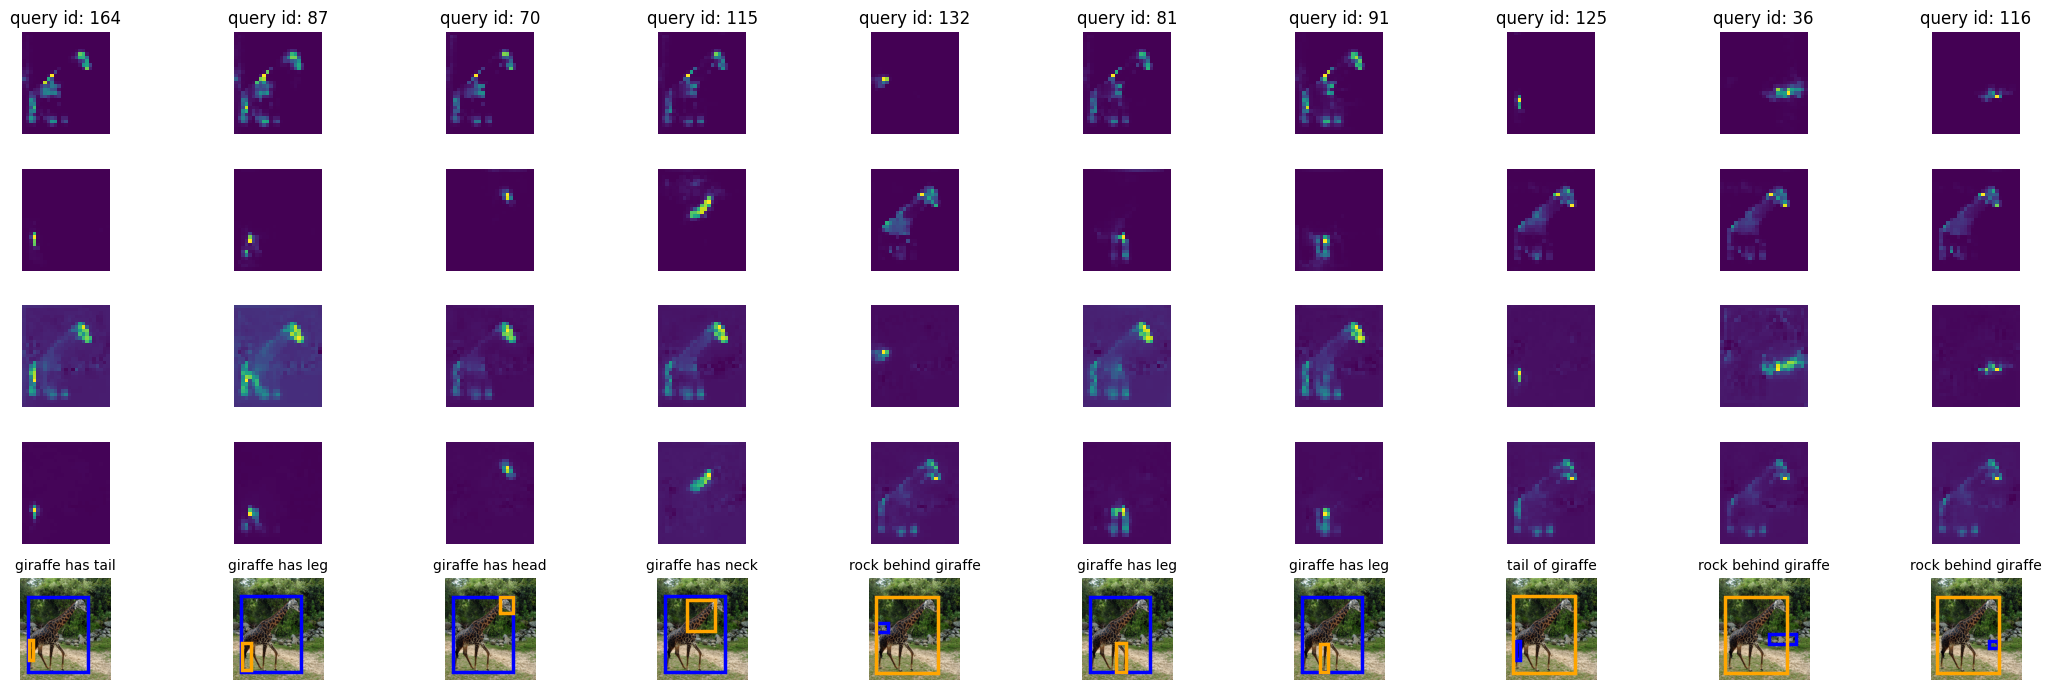

In [25]:
visualize_layer(model, img, layer_exit=4)

In [26]:
visualize_layer(model, img, layer_exit=5)

Execution time 0.06439590454101562


IndexError: list index out of range

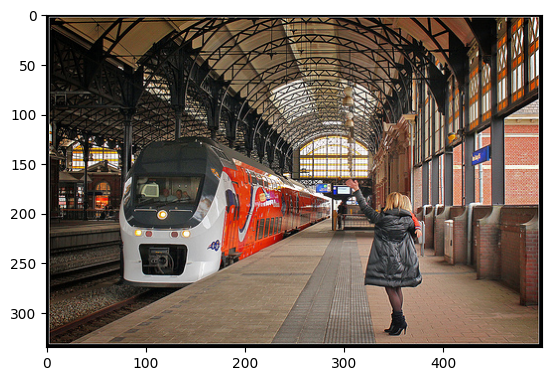

In [39]:
# img_path = 'demo/vg1.jpg'
img_path = 'data/vg/images/2417977.jpg'
# img_path = 'data/vg/images/2417949.jpg'
im= Image.open(img_path)
plt.imshow(im)
# im = resize_image(im, 708,800)
img = transform(im).unsqueeze(0)
img = img.to(device)

Execution time 0.05653667449951172
Real decoders executed till layer 0


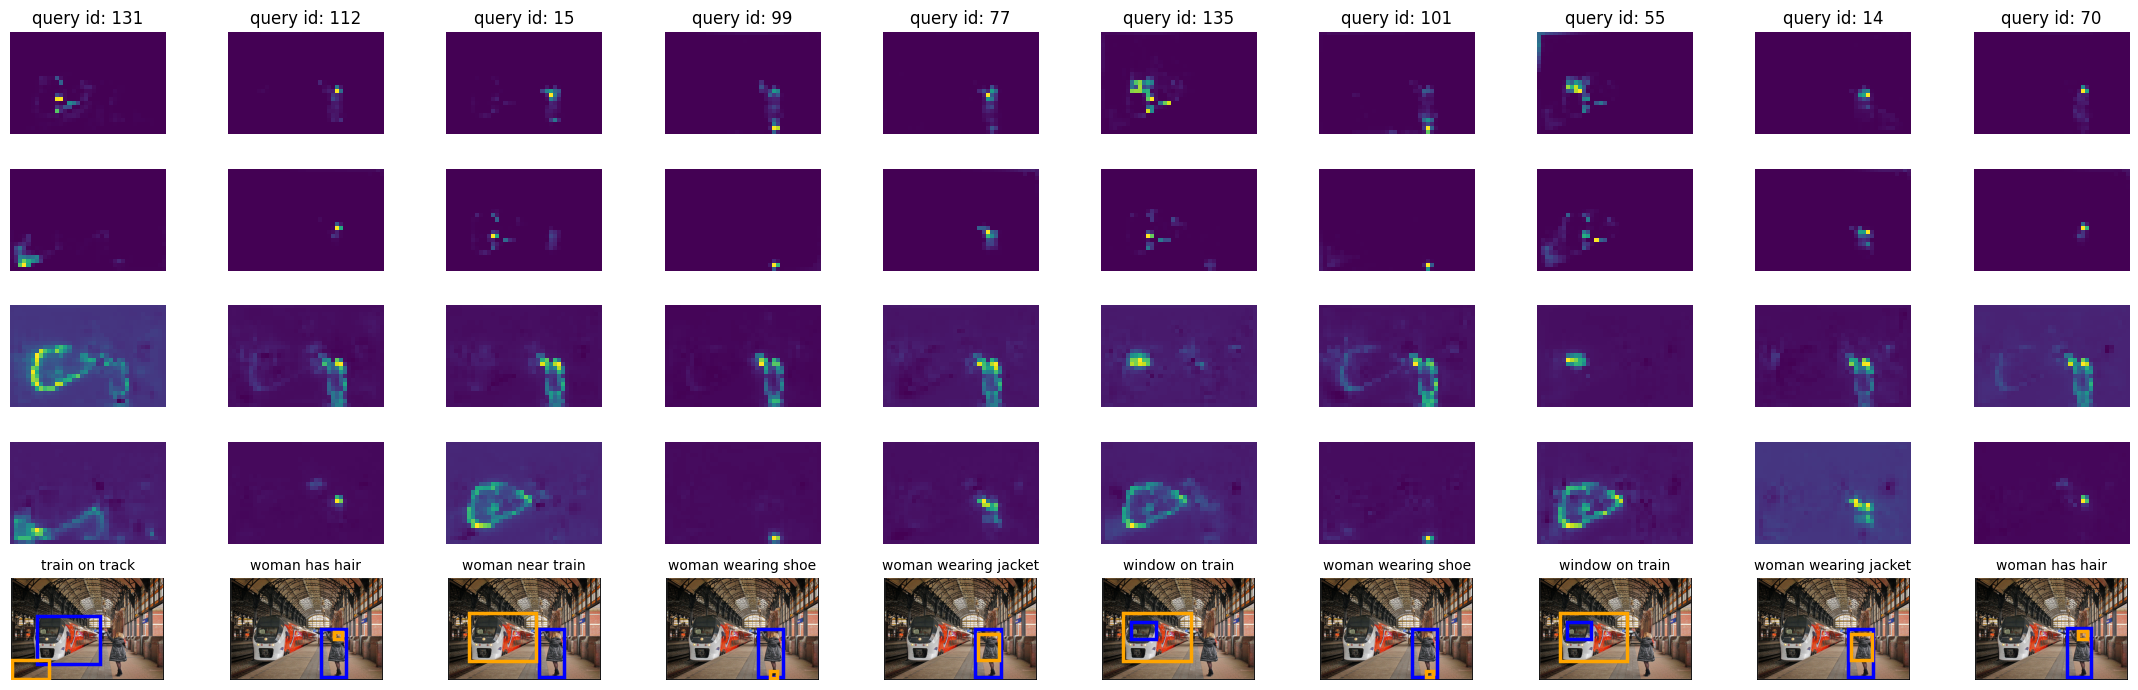

In [40]:
visualize_layer(model, img, layer_exit=0)

Execution time 0.06094241142272949
Real decoders executed till layer 1


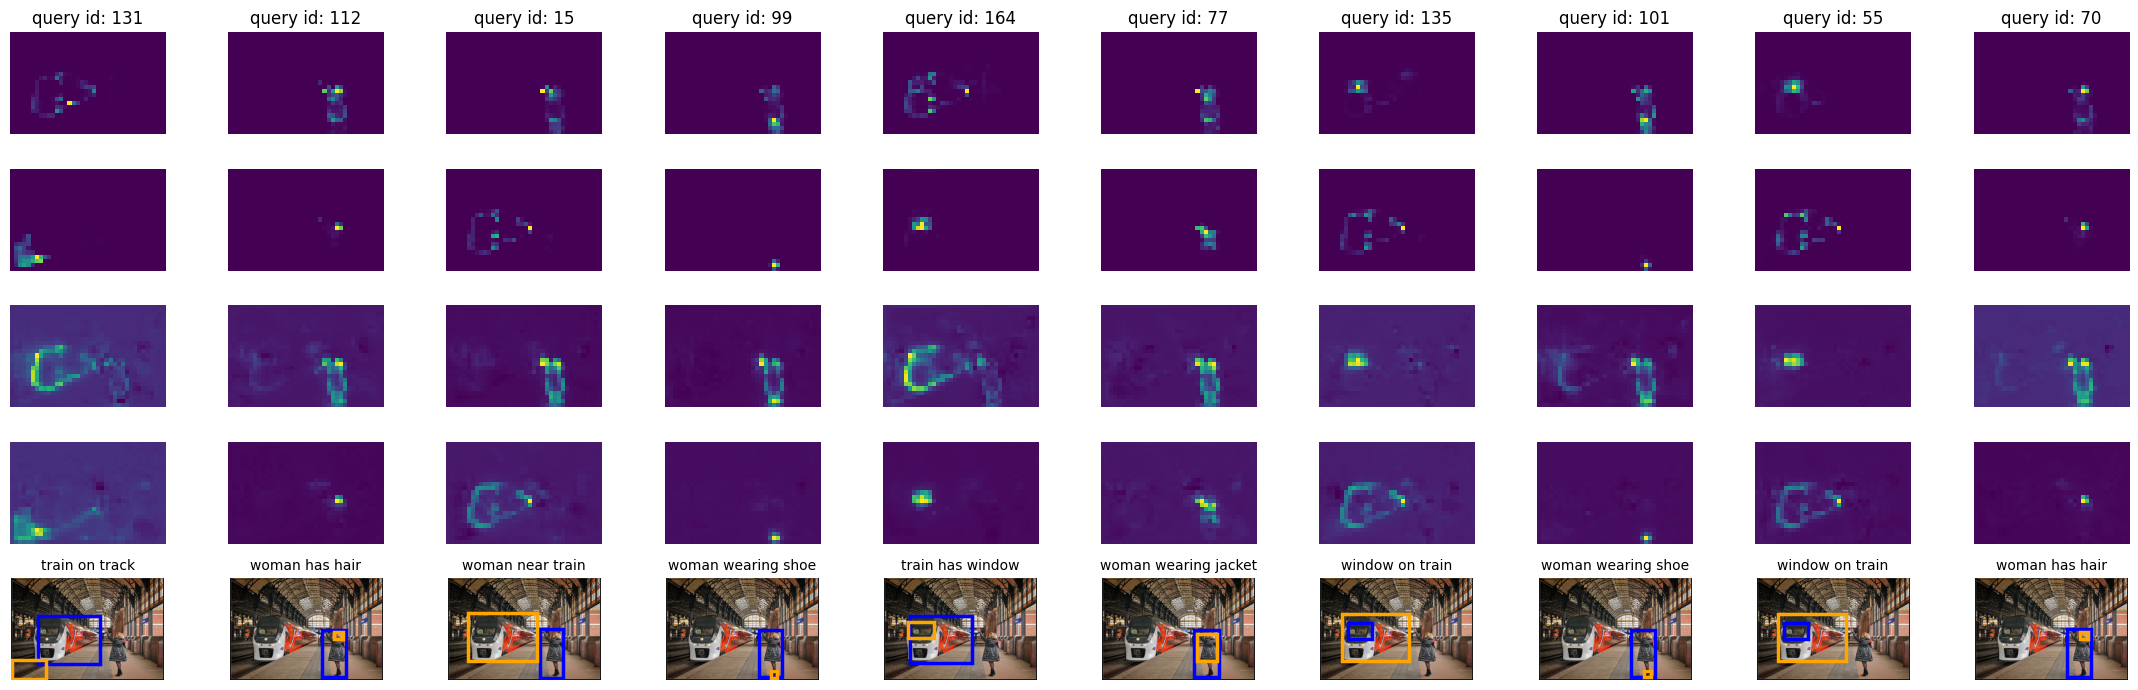

In [42]:
visualize_layer(model, img, layer_exit=1)

Execution time 0.06484031677246094
Real decoders executed till layer 2


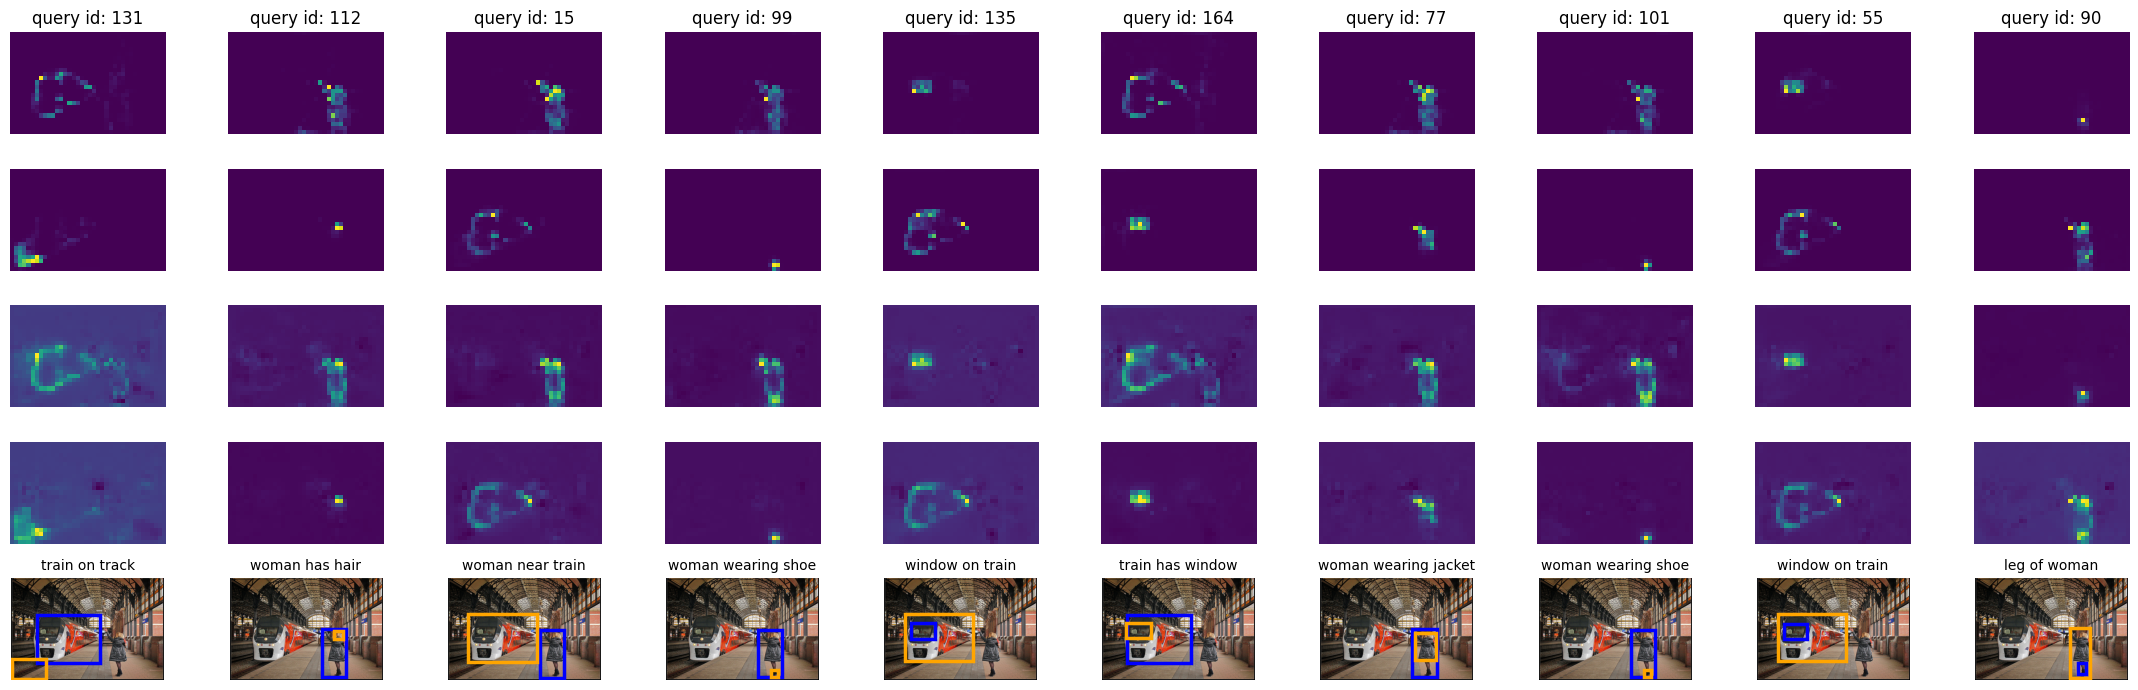

In [43]:
visualize_layer(model, img, layer_exit=2)

Execution time 0.06819415092468262
Real decoders executed till layer 3


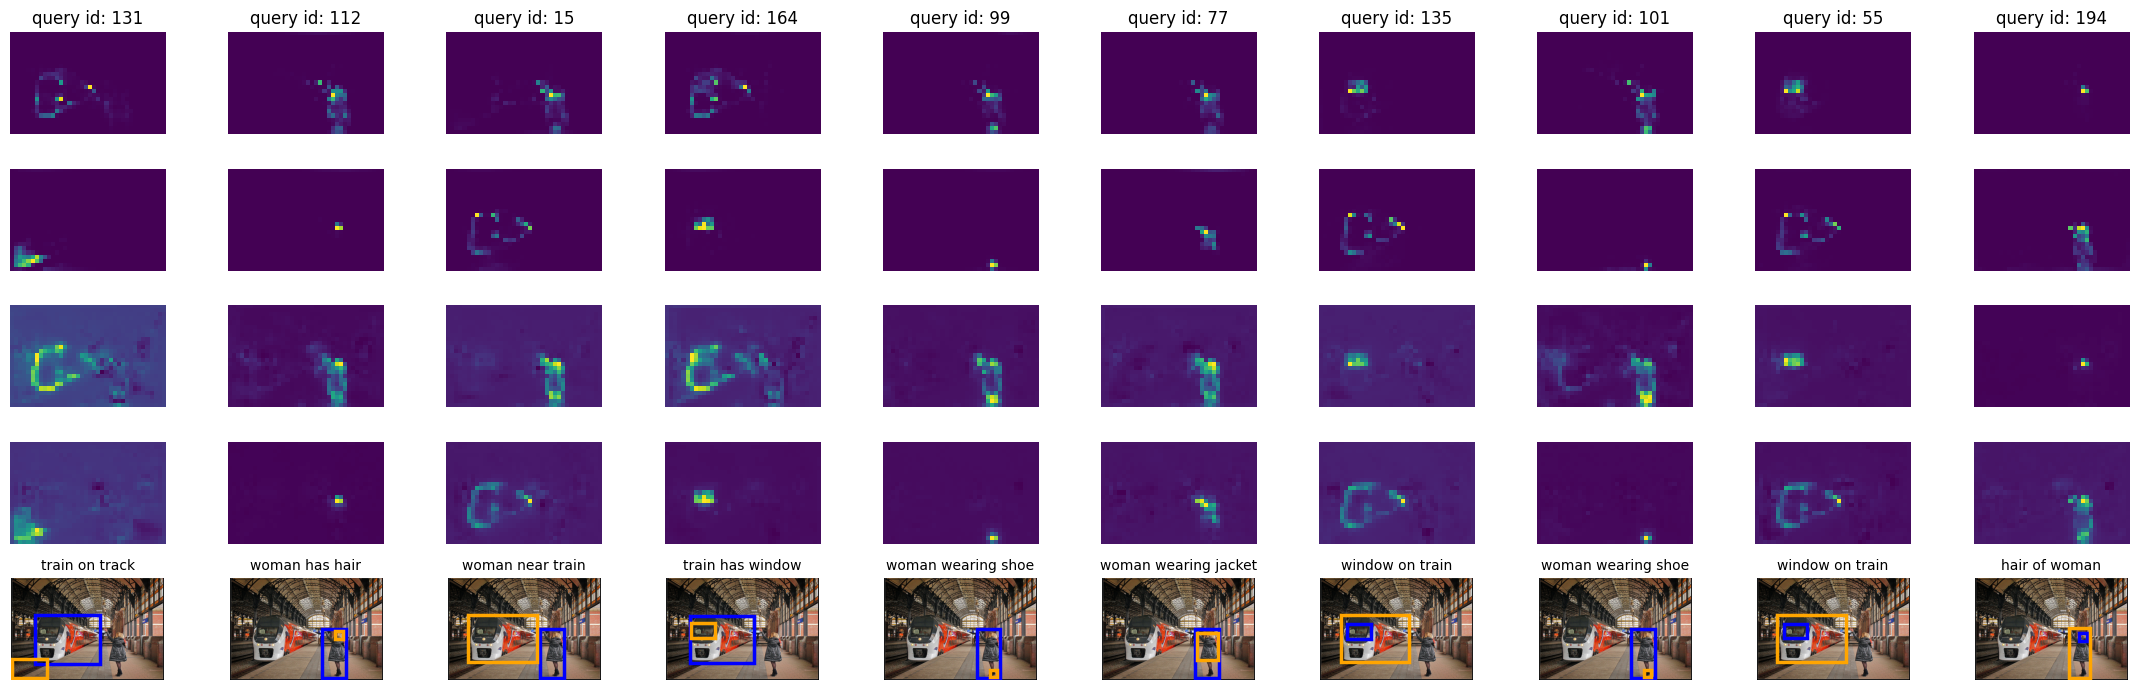

In [44]:
visualize_layer(model, img, layer_exit=3)

Execution time 0.07212567329406738
Real decoders executed till layer 4


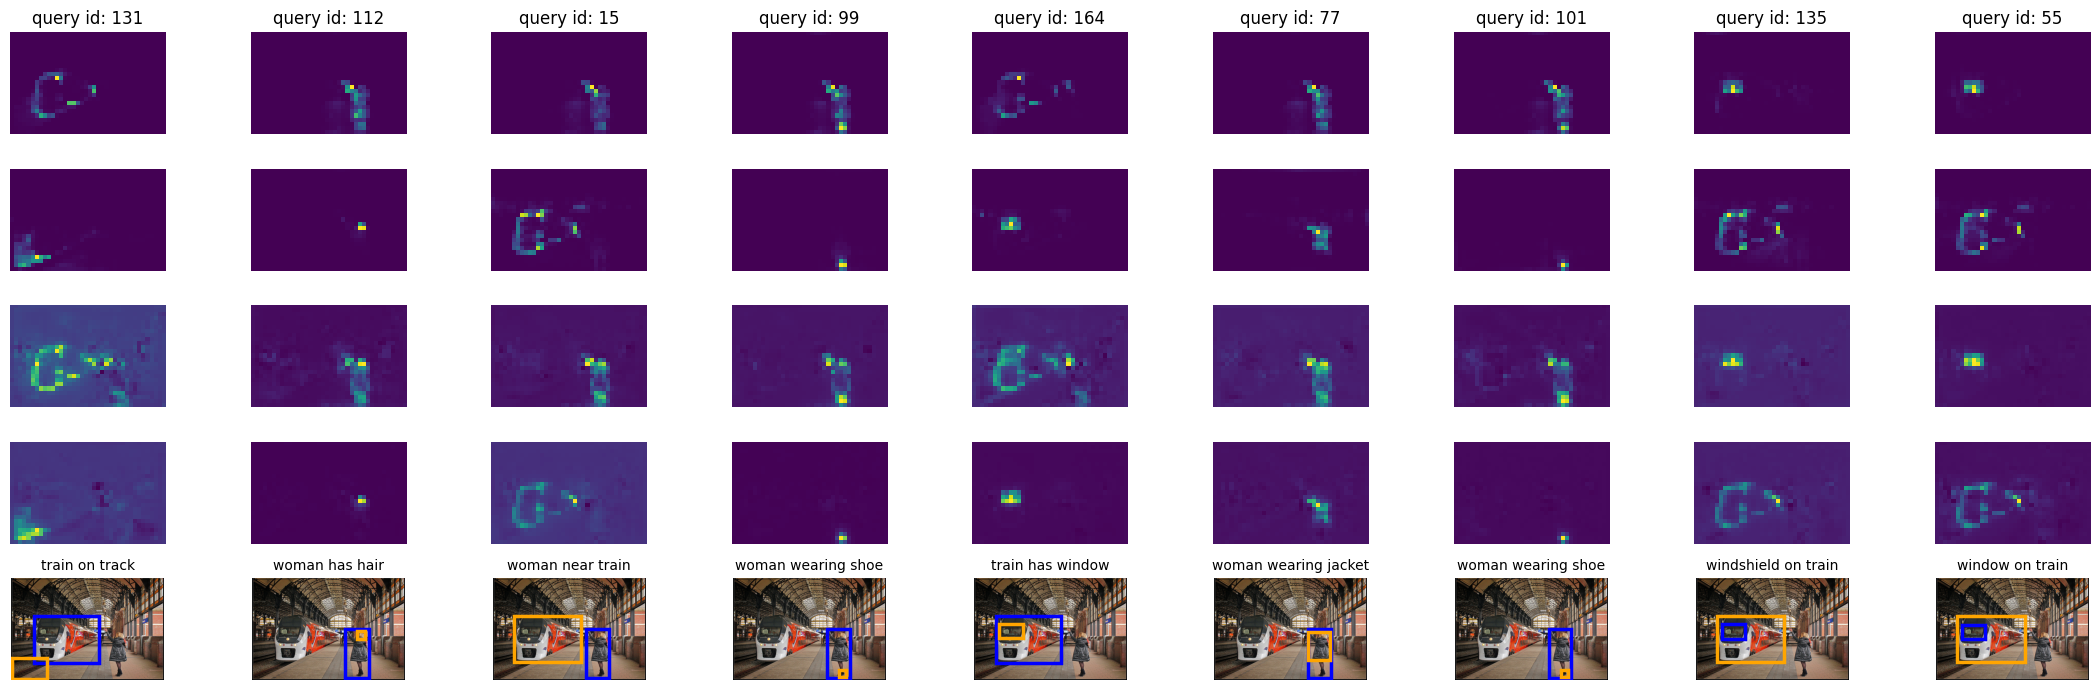

In [45]:
visualize_layer(model, img, layer_exit=4)

In [46]:
visualize_layer(model, img, layer_exit=5)

Execution time 0.07701706886291504


IndexError: list index out of range

TODOs:

1. Train on whole data
3. Incorporate shallow feature mixing
4. Validate/experiment early exit criteria (confidence)
5. Quanitfy metrics - quality and time
6. code clean!!!

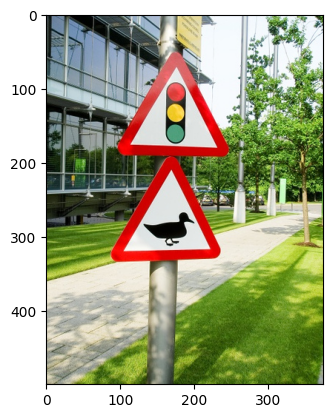

In [48]:
img_path = 'demo/vg3.jpg'
im= Image.open(img_path)
plt.imshow(im)
# im = resize_image(im, 708,800)
img = transform(im).unsqueeze(0)
img = img.to(device)

Execution time 0.05324983596801758
Real decoders executed till layer 0


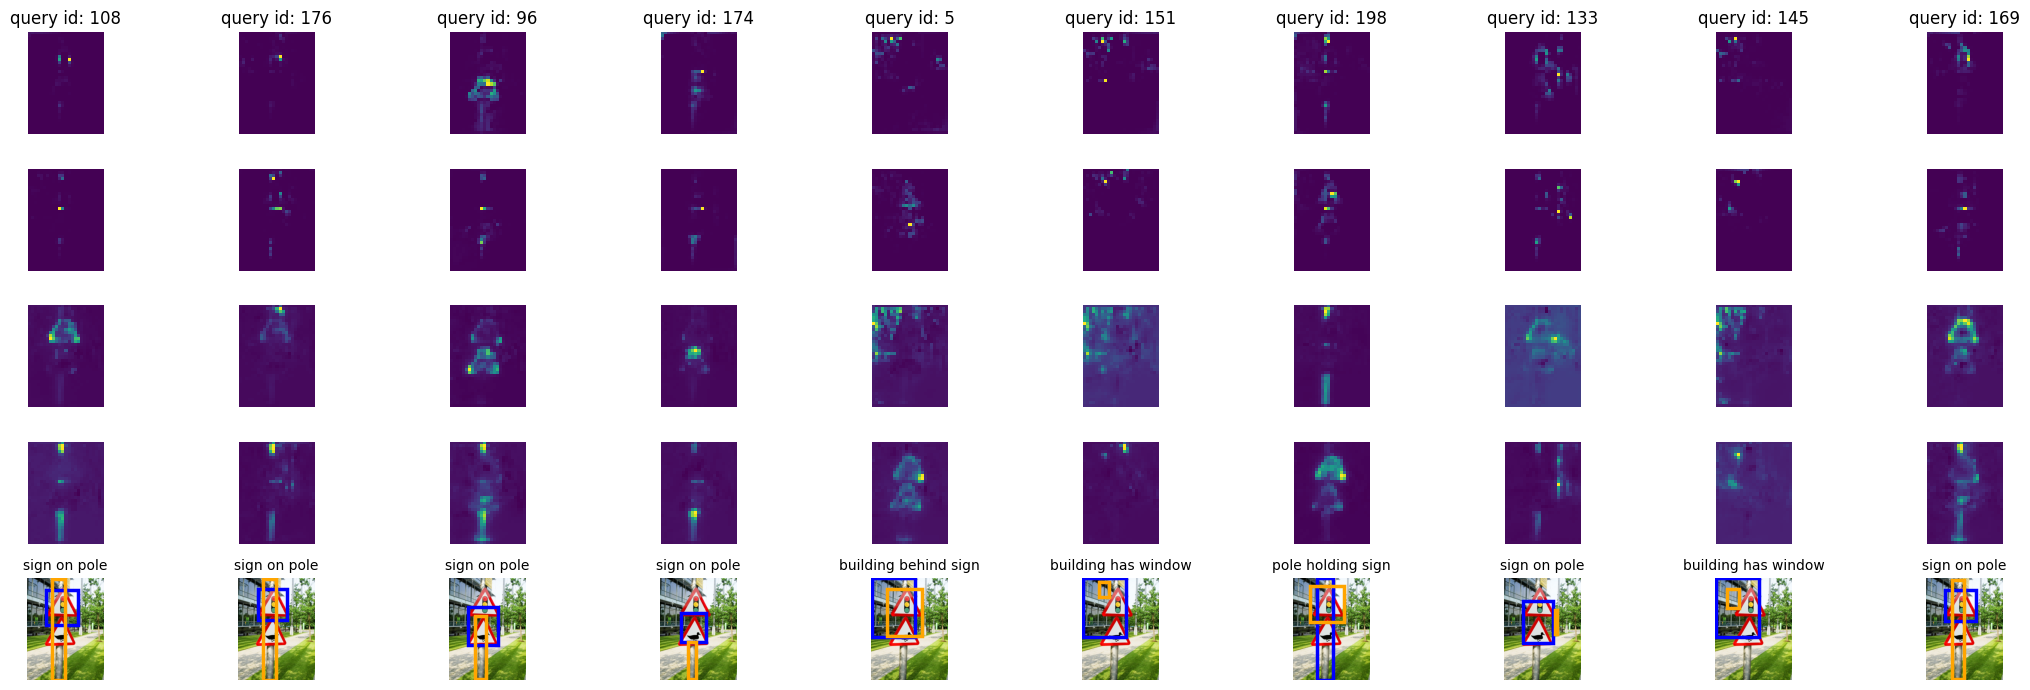

In [49]:
visualize_layer(model, img, layer_exit=0)

Execution time 0.05411052703857422
Real decoders executed till layer 1


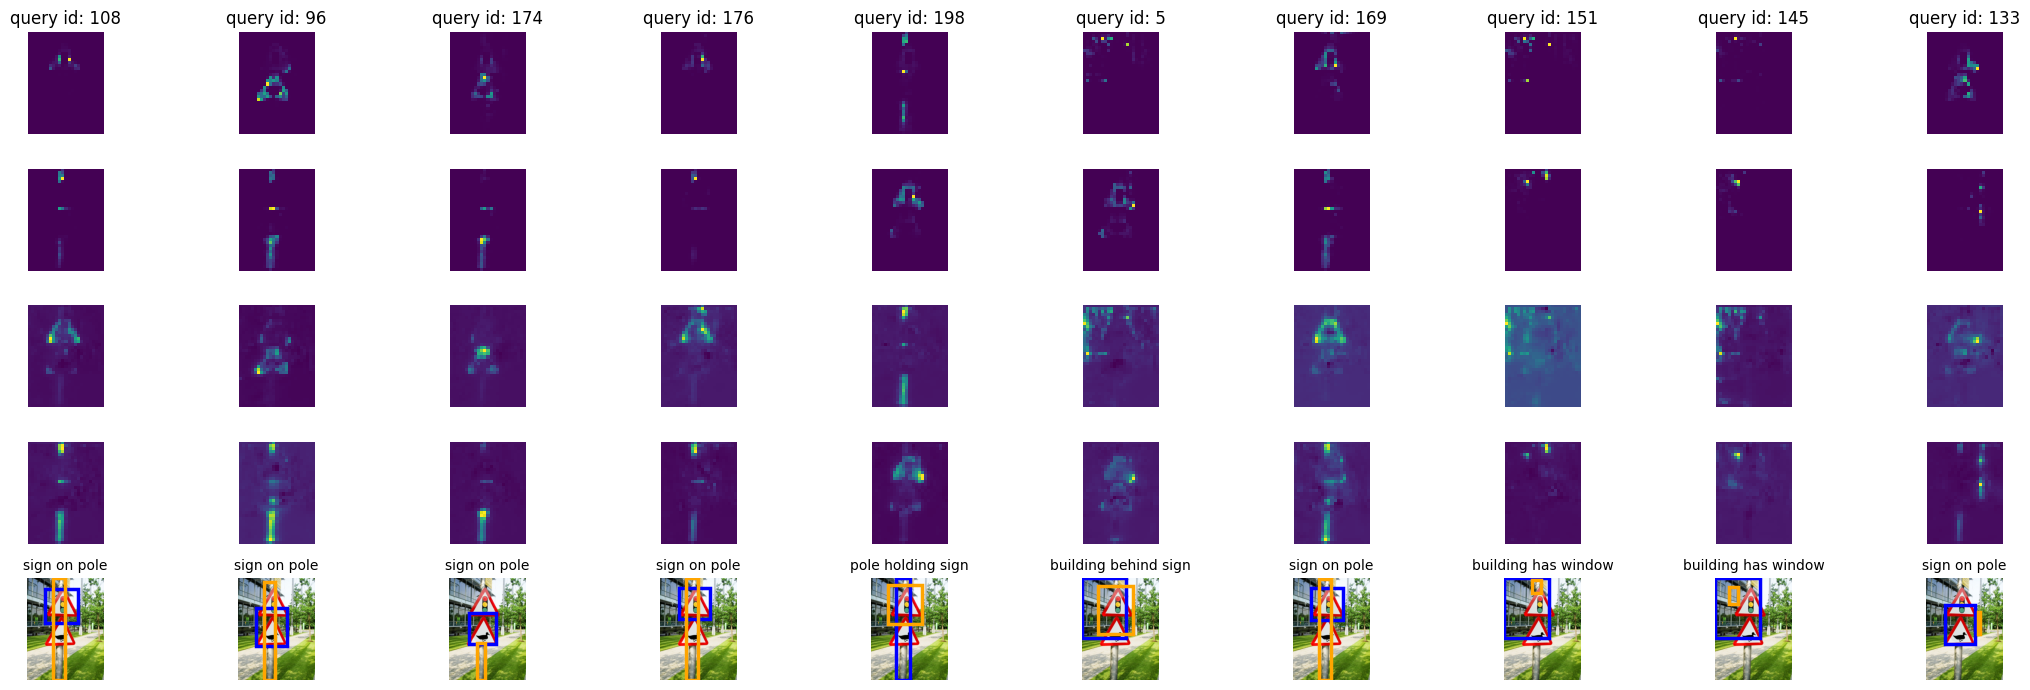

In [50]:
visualize_layer(model, img, layer_exit=1)

Execution time 0.05799436569213867
Real decoders executed till layer 2


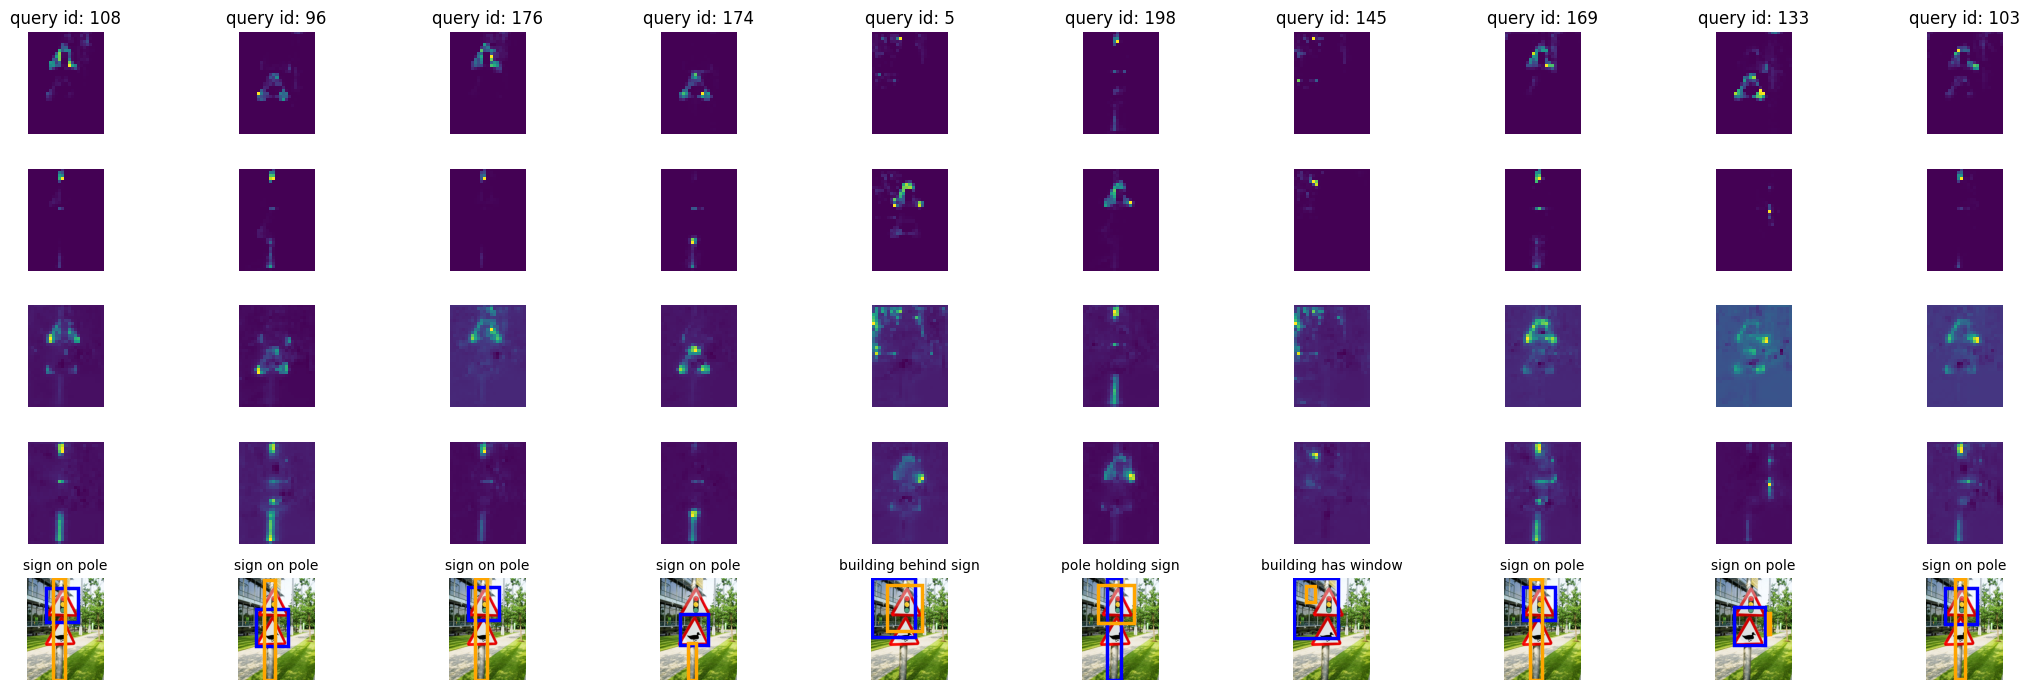

In [51]:
visualize_layer(model, img, layer_exit=2)

Execution time 0.0615994930267334
Real decoders executed till layer 3


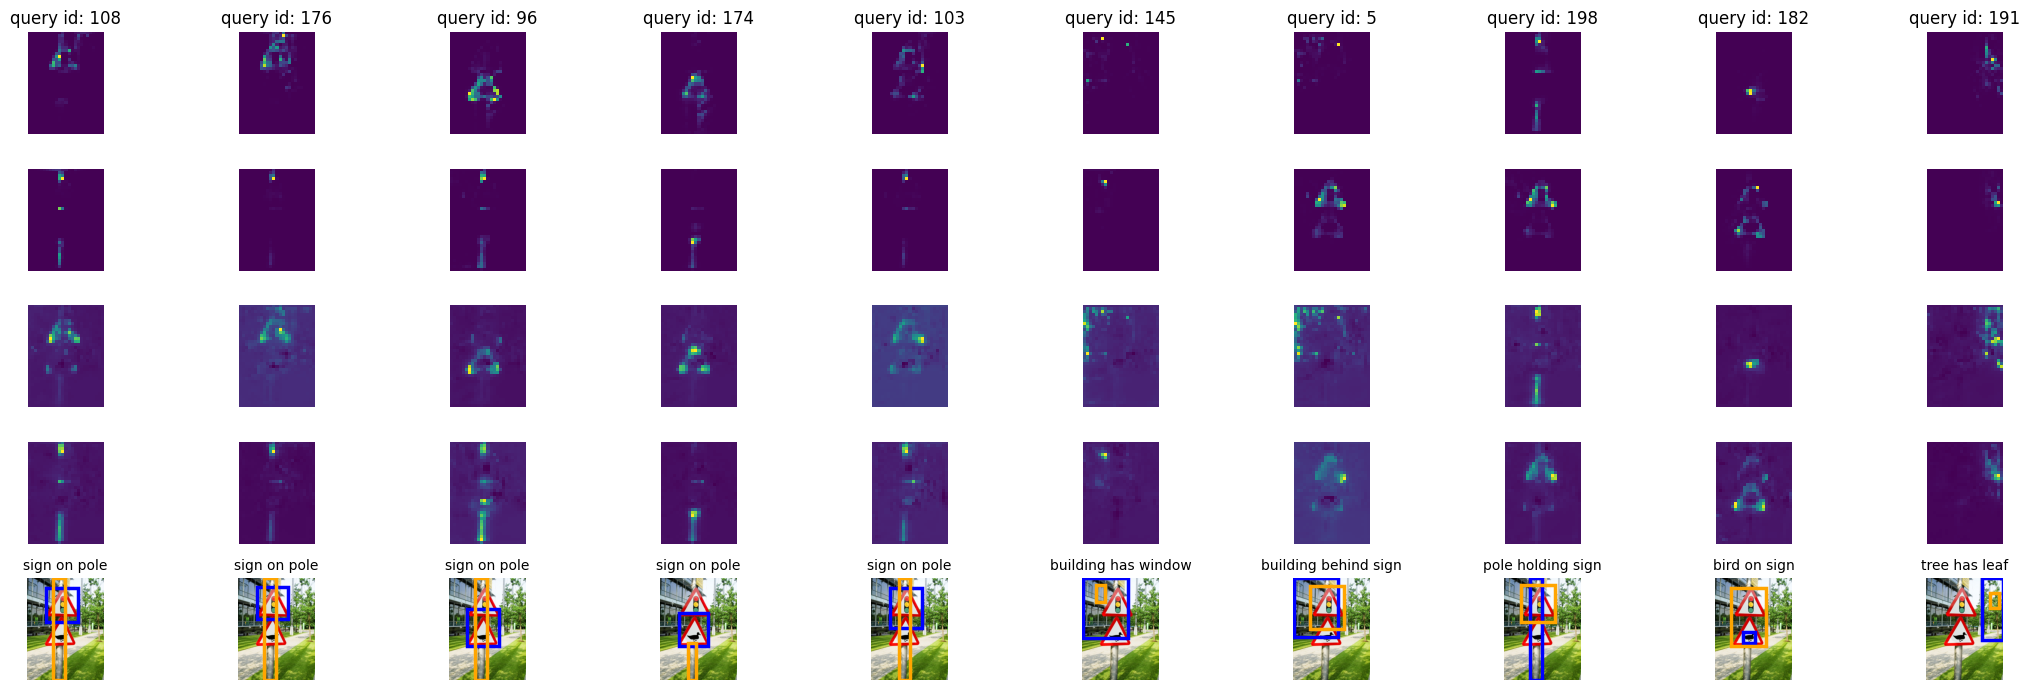

In [52]:
visualize_layer(model, img, layer_exit=3)

Execution time 0.06580114364624023
Real decoders executed till layer 4


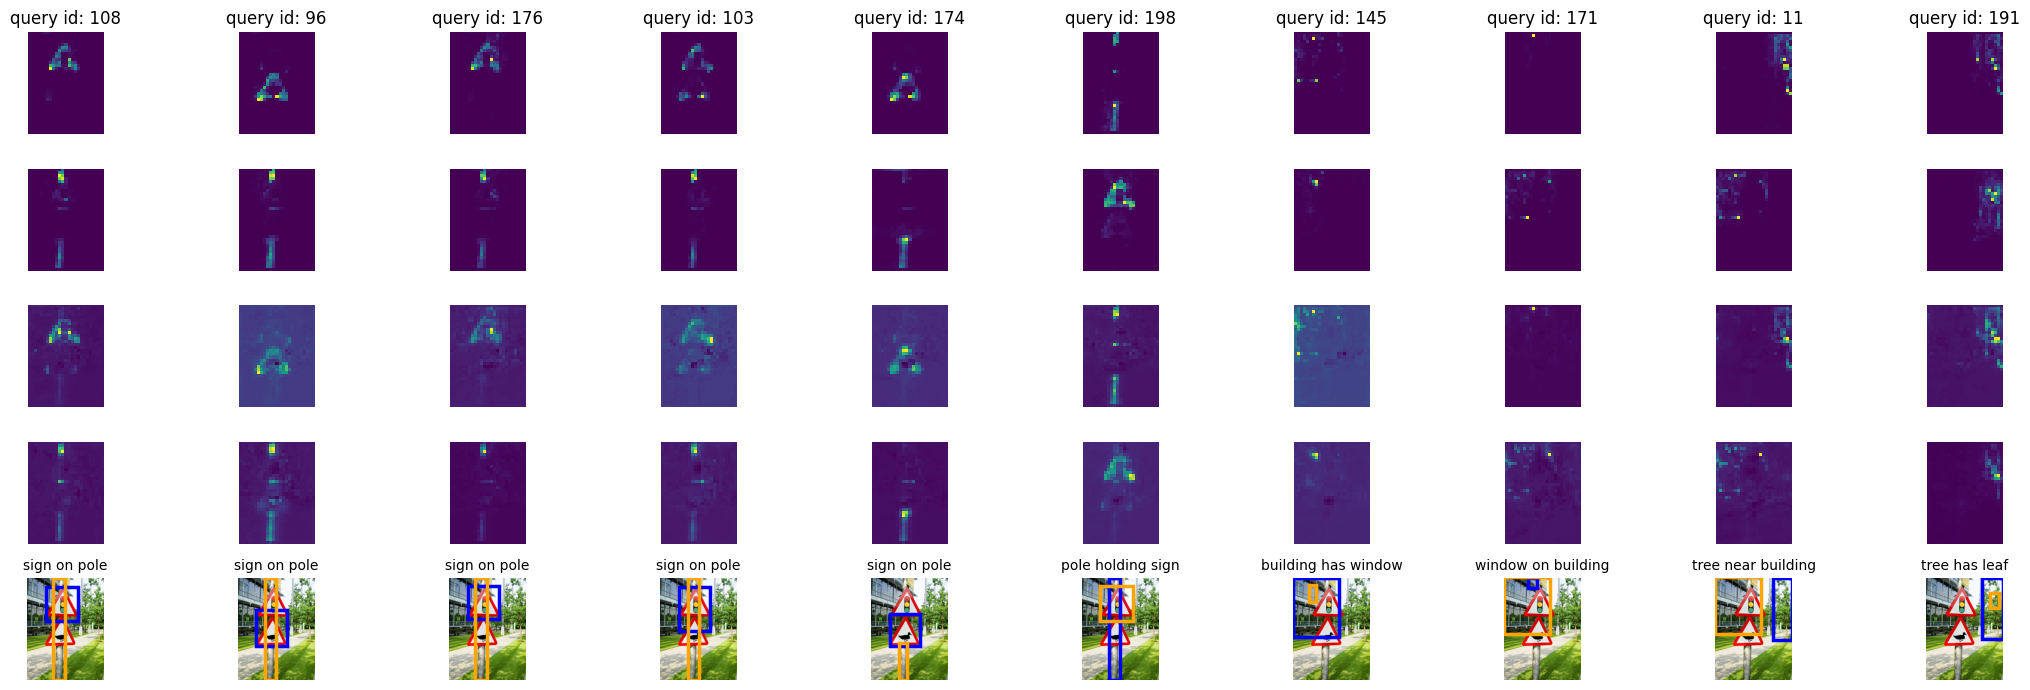

In [53]:
visualize_layer(model, img, layer_exit=4)